In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#essential data preparation, all except categories

# item 6197 had wrong encoding for utf-8 to handle, so it had to be downgraded to latin-1
super_data = pd.read_csv('/kaggle/input/superstore-sales-dataset/SuperStore_Orders.csv', encoding='latin-1')

#the problematic item is super_data.loc[6197] 

#changing data type for sales to integers
super_data.sales.replace('\D', '', regex=True, inplace=True)
super_data['sales'] = super_data['sales'].astype('int64')
super_data['profit'] = super_data['profit'].astype('int64')

#years to objects since datetime is not relevant to our analysis
super_data['year'] = super_data['year'].astype('object')
super_data.info()
#no null values in this dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        51290 non-null  object 
 1   order_date      51290 non-null  object 
 2   ship_date       51290 non-null  object 
 3   ship_mode       51290 non-null  object 
 4   customer_name   51290 non-null  object 
 5   segment         51290 non-null  object 
 6   state           51290 non-null  object 
 7   country         51290 non-null  object 
 8   market          51290 non-null  object 
 9   region          51290 non-null  object 
 10  product_id      51290 non-null  object 
 11  category        51290 non-null  object 
 12  sub_category    51290 non-null  object 
 13  product_name    51290 non-null  object 
 14  sales           51290 non-null  int64  
 15  quantity        51290 non-null  int64  
 16  discount        51290 non-null  float64
 17  profit          51290 non-null 

In [3]:
super_data.head()

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,...,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,year
0,AG-2011-2040,01-01-2011,06-01-2011,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,...,Office Supplies,Storage,"Tenex Lockers, Blue",408,2,0.0,106,35.46,Medium,2011
1,IN-2011-47883,01-01-2011,08-01-2011,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,...,Office Supplies,Supplies,"Acme Trimmer, High Speed",120,3,0.1,36,9.72,Medium,2011
2,HU-2011-1220,01-01-2011,05-01-2011,Second Class,Annie Thurman,Consumer,Budapest,Hungary,EMEA,EMEA,...,Office Supplies,Storage,"Tenex Box, Single Width",66,4,0.0,29,8.17,High,2011
3,IT-2011-3647632,01-01-2011,05-01-2011,Second Class,Eugene Moren,Home Office,Stockholm,Sweden,EU,North,...,Office Supplies,Paper,"Enermax Note Cards, Premium",45,3,0.5,-26,4.82,High,2011
4,IN-2011-47883,01-01-2011,08-01-2011,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,...,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",114,5,0.1,37,4.70,Medium,2011


# Aims of EDA:
* Detemine profitability of the business
* Analyse factors impacting profits by considering promising markets, regions, customer segments and inventory
* Prepare summary observations and recommendations in terms of profit loss

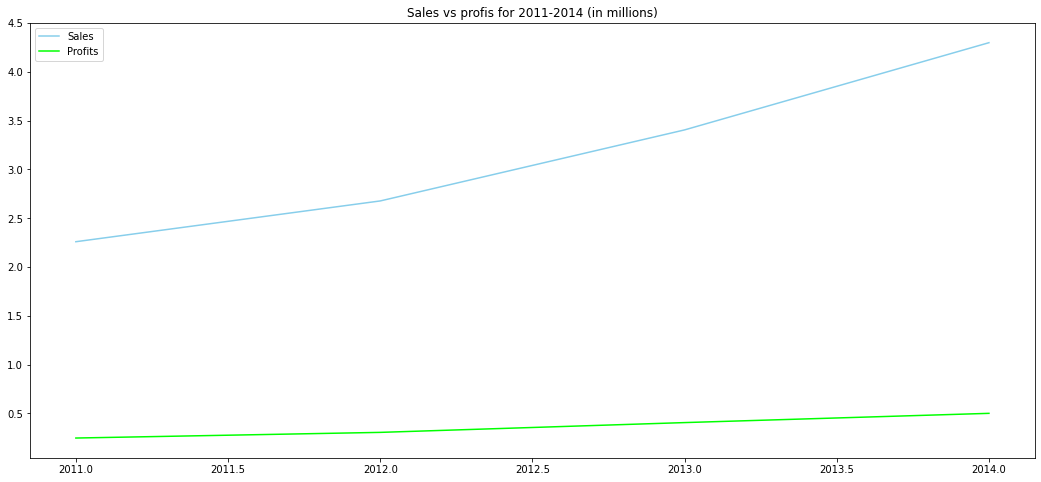

In [4]:
#Annual sales and profits

sales_ann = super_data.groupby('year')['sales'].sum().reset_index()
profit_ann = super_data.groupby('year')['profit'].sum().reset_index()

plt.figure(figsize=[18,8])
plt.title("Sales vs profis for 2011-2014 (in millions)")
plt.plot(sales_ann['year'], sales_ann['sales'] /1000000, color='skyblue')
plt.plot(profit_ann['year'], profit_ann['profit'] / 1000000, color='lime')
plt.legend(['Sales', 'Profits'])
plt.show()

There is healthy growth in sales but the profits are less pronounced and there is an increasing gap between them, nearing approximately 3.8 million in 2014.

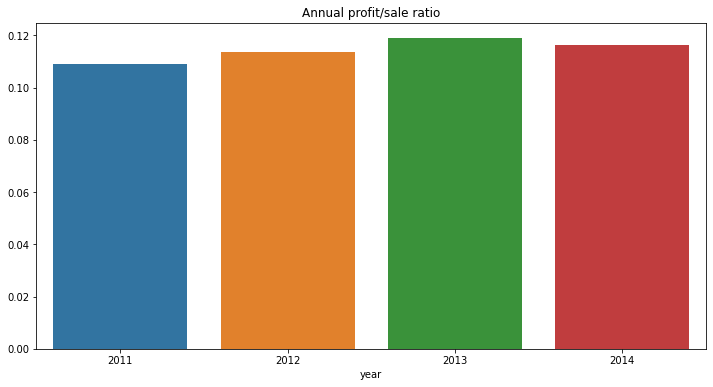

In [5]:
prof_by_sale = profit_ann['profit'] / sales_ann['sales']

plt.figure(figsize=[12,6])
sns.barplot(y=prof_by_sale, x=sales_ann['year'])
plt.title("Annual profit/sale ratio")
plt.show()

The profit-to-sale ratio even decreased slighly in 2014, after growing steadily for the previous 3 years.

# Pt I: Regional and market analysis of profit loss. Country-level analysis of problematic areas.

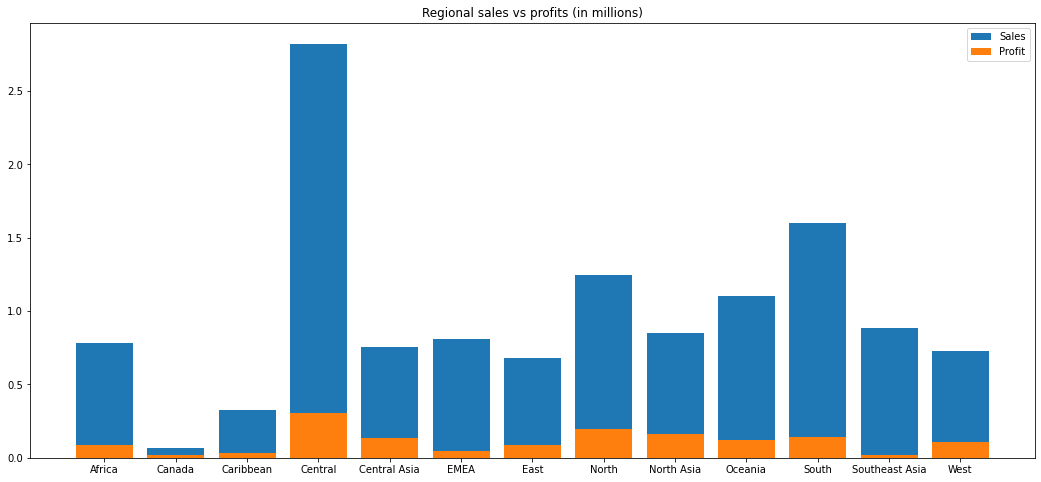

In [6]:
# total regional profits and sales

regions_profits = super_data.groupby('region')['profit'].sum().reset_index()
regions_sales = super_data.groupby('region')['sales'].sum().reset_index()

plt.figure(figsize=[18,8])
plt.bar(regions_sales['region'], regions_sales['sales']/ 1000000)
plt.bar(regions_profits['region'], regions_profits['profit']/ 1000000)
plt.legend(['Sales', 'Profit'])
plt.title("Regional sales vs profits (in millions)")
plt.show()

The biggest discrepancy between sales and profits is observed in EMEA, Southeast Asia and the South.The best results are shown by Canada, North and central Asia, and the Northern region. 

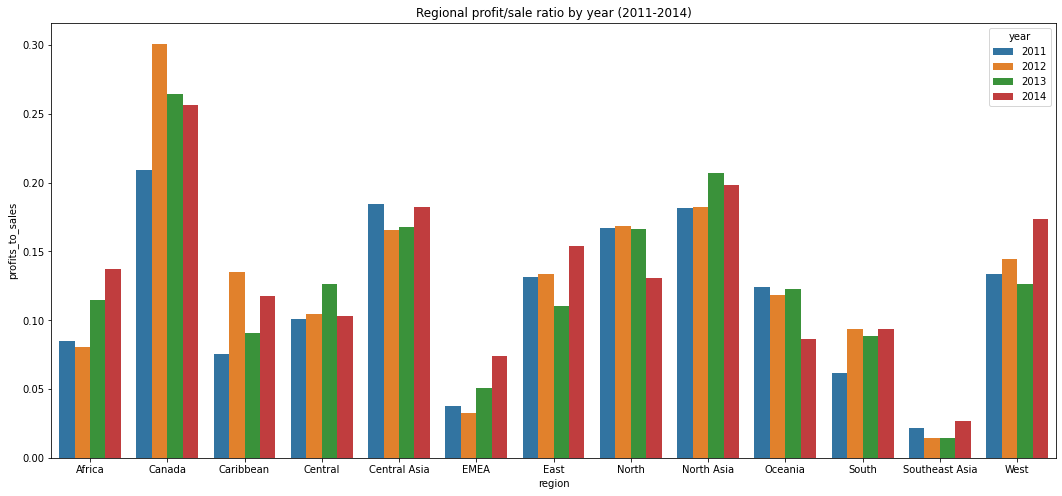

In [7]:
#profits vs sales in regions by year
regions_profits_ann = super_data.groupby(['region', 'year'])['profit'].sum().reset_index()
regions_sales_ann = super_data.groupby(['region', 'year'])['sales'].sum().reset_index()
reg_profits_to_sales_ann = regions_profits_ann['profit'] / regions_sales_ann['sales']
regions_sales_ann['profits'] = regions_profits_ann['profit']
regions_sales_ann['profits_to_sales'] = reg_profits_to_sales_ann

plt.figure(figsize=[18,8])
sns.barplot(data=regions_sales_ann, x='region', y='profits_to_sales', hue='year')
plt.title('Regional profit/sale ratio by year (2011-2014)')
plt.show()

There are five regions that display a fall in profits-to-sales in 2014: Canada, Central, North, North Asia, Oceania. For more information it might be useful to analyse the *markets? countries* as well.

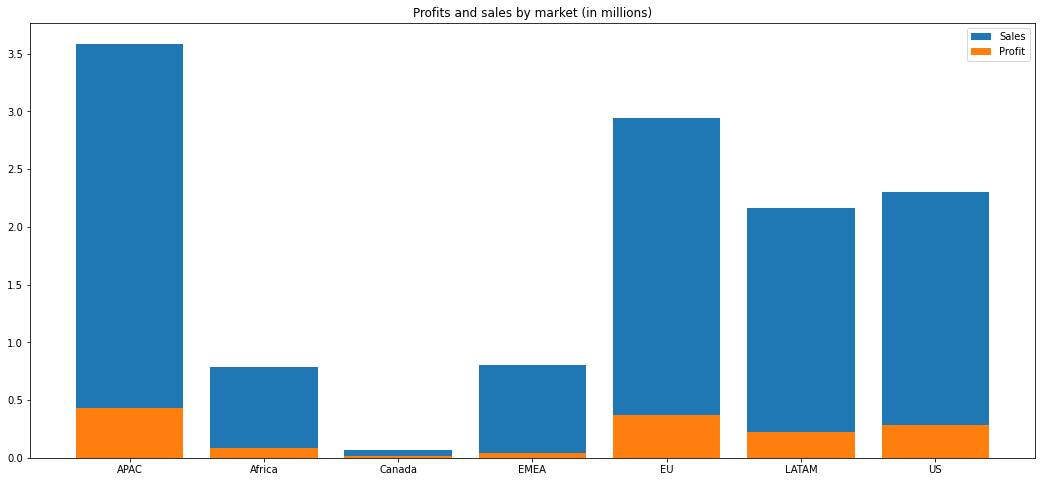

In [8]:
#sales and profits by market
markets_sales = super_data.groupby('market')['sales'].sum().reset_index()
markets_profits = super_data.groupby('market')['profit'].sum().reset_index()

plt.figure(figsize=[18,8])
plt.bar(markets_sales['market'], markets_sales['sales'] / 1000000)
plt.bar(markets_profits['market'], markets_profits['profit'] / 1000000)
plt.legend(['Sales', 'Profit'])
plt.title("Profits and sales by market (in millions)")
plt.show()

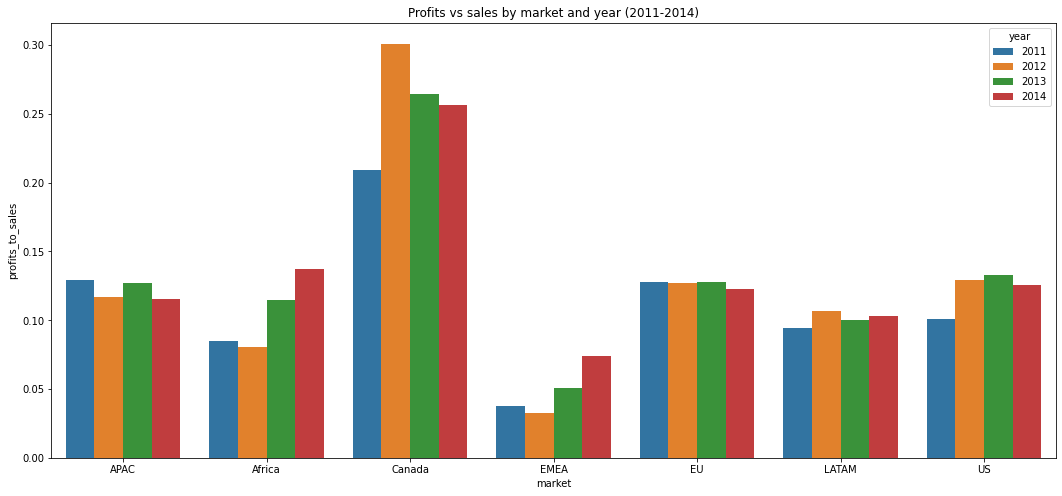

In [9]:
#ratio visualisation
markets_profits_ann = super_data.groupby(['market', 'year'])['profit'].sum().reset_index()
markets_sales_ann = super_data.groupby(['market', 'year'])['sales'].sum().reset_index()
m_profits_to_sales_ann = markets_profits_ann['profit'] / markets_sales_ann['sales']
markets_sales_ann['profits'] = markets_profits_ann['profit']
markets_sales_ann['profits_to_sales'] = m_profits_to_sales_ann

plt.figure(figsize=[18,8])
sns.barplot(data=markets_sales_ann, x='market', y='profits_to_sales', hue='year')
plt.title("Profits vs sales by market and year (2011-2014)")
plt.show()

There is a similar trend in markets, with EMEA trailing behind, and Canada in the lead. However, the results in terms of profit-to-loss correlation are much more uniform.

The markets that show a decrease in 2014: APAC, Canada, being the strongest overall, EU, US.

It is likely that special attention should be paid in the overlap countries that appear in both underperforming regions and markets, like Canada. Additional expansion might be considered.

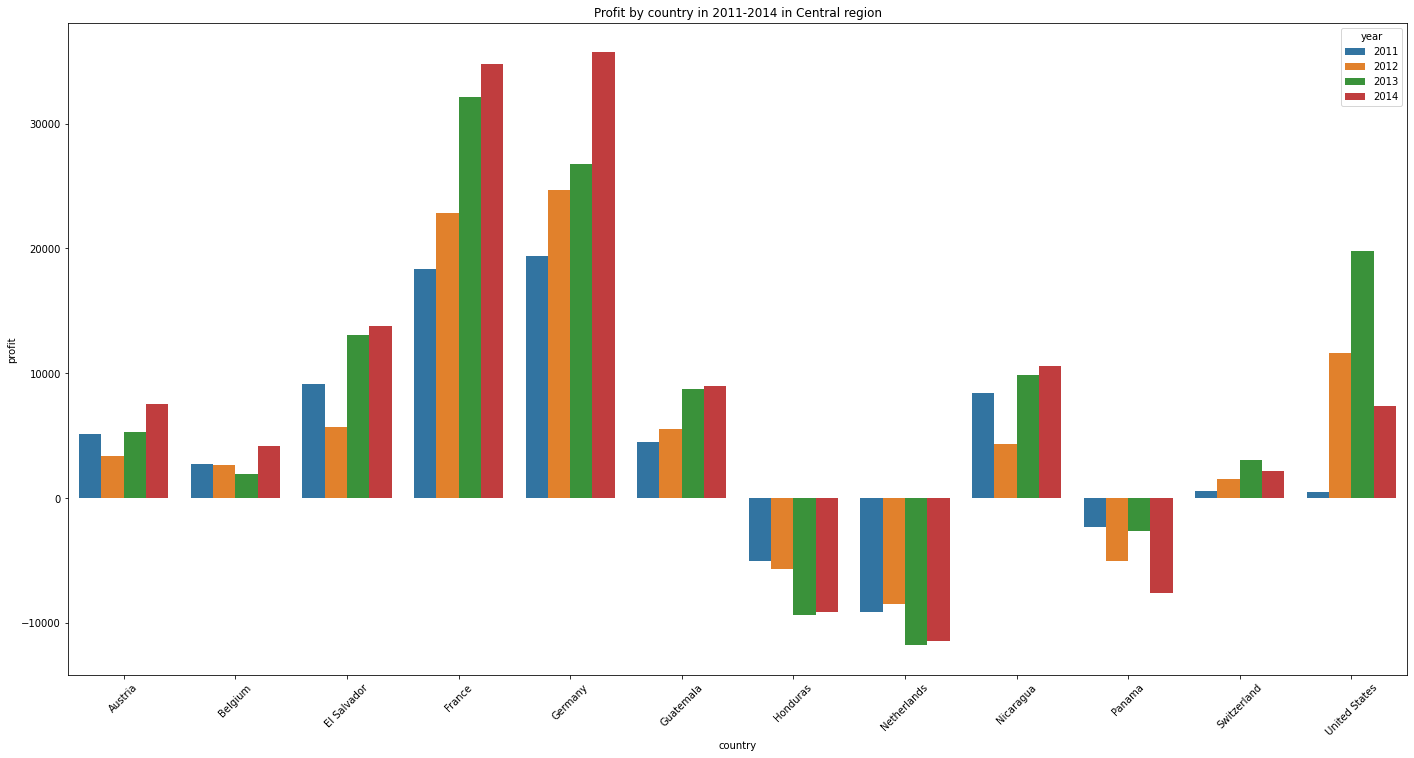

In [10]:
#problem countries in Central, North, North Asia, Oceania regions

reg_countries = super_data.groupby(['region','country','year'])['profit'].sum().reset_index()
countries_central = reg_countries[reg_countries['region'] == 'Central'].reset_index()

plt.figure(figsize=[24,12])
sns.barplot(data=countries_central, x='country', y='profit', hue='year')
plt.xticks(rotation=45)
plt.title("Profit by country in 2011-2014 in Central region")
plt.show()

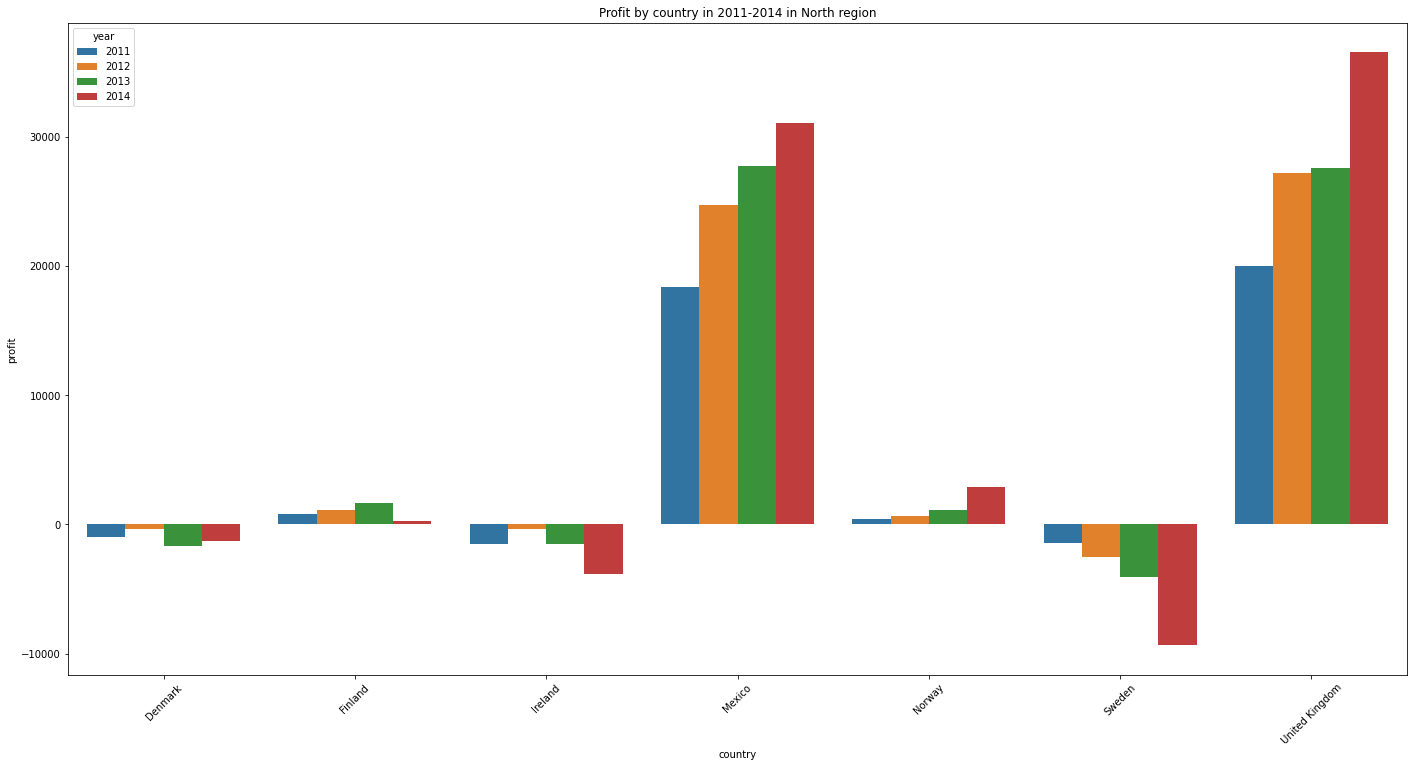

In [11]:
countries_north = reg_countries[reg_countries['region'] == 'North'].reset_index()

plt.figure(figsize=[24,12])
sns.barplot(data=countries_north, x='country', y='profit', hue='year')
plt.xticks(rotation=45)
plt.title("Profit by country in 2011-2014 in North region")
plt.show()

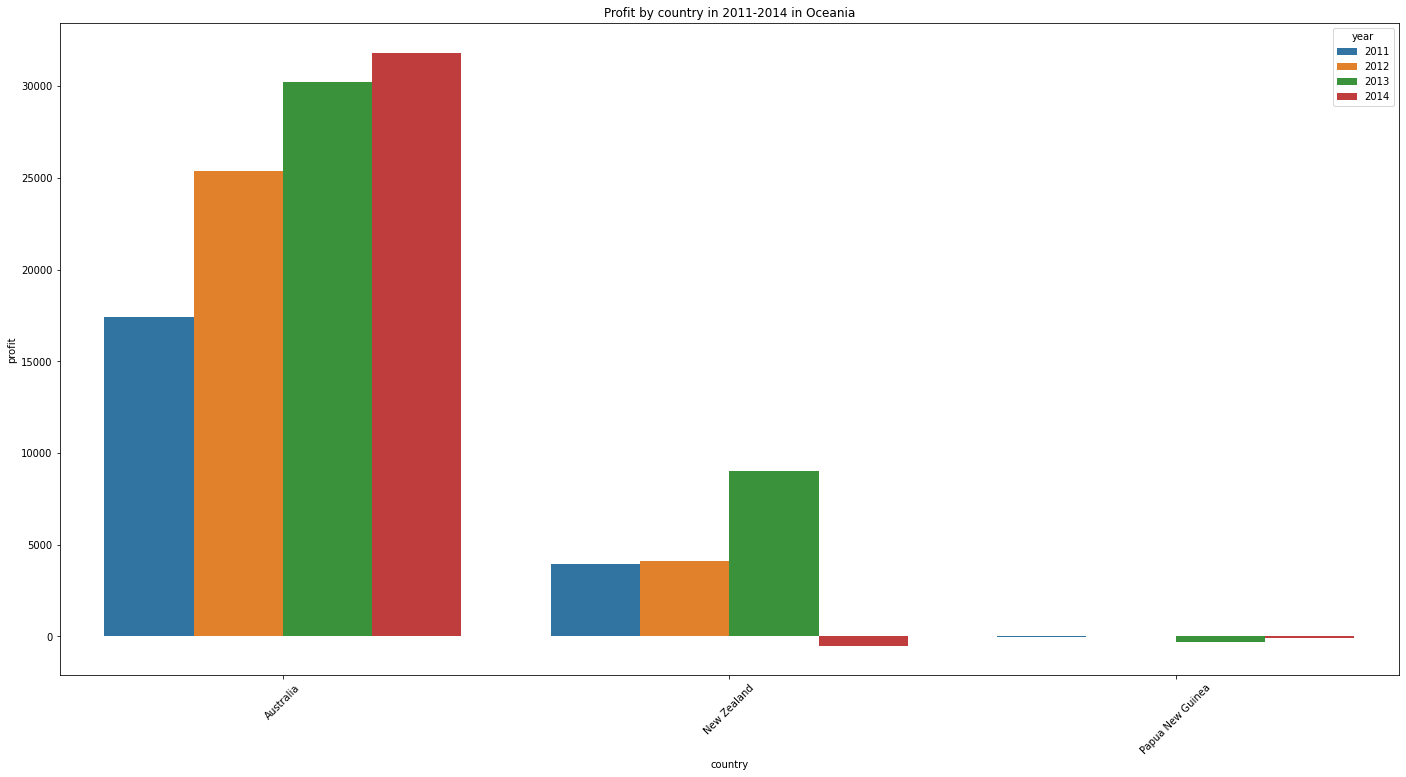

In [12]:
countries_oceania = reg_countries[reg_countries['region'] == 'Oceania'].reset_index()

plt.figure(figsize=[24,12])
sns.barplot(data=countries_oceania, x='country', y='profit', hue='year')
plt.xticks(rotation=45)
plt.title("Profit by country in 2011-2014 in Oceania")
plt.show()

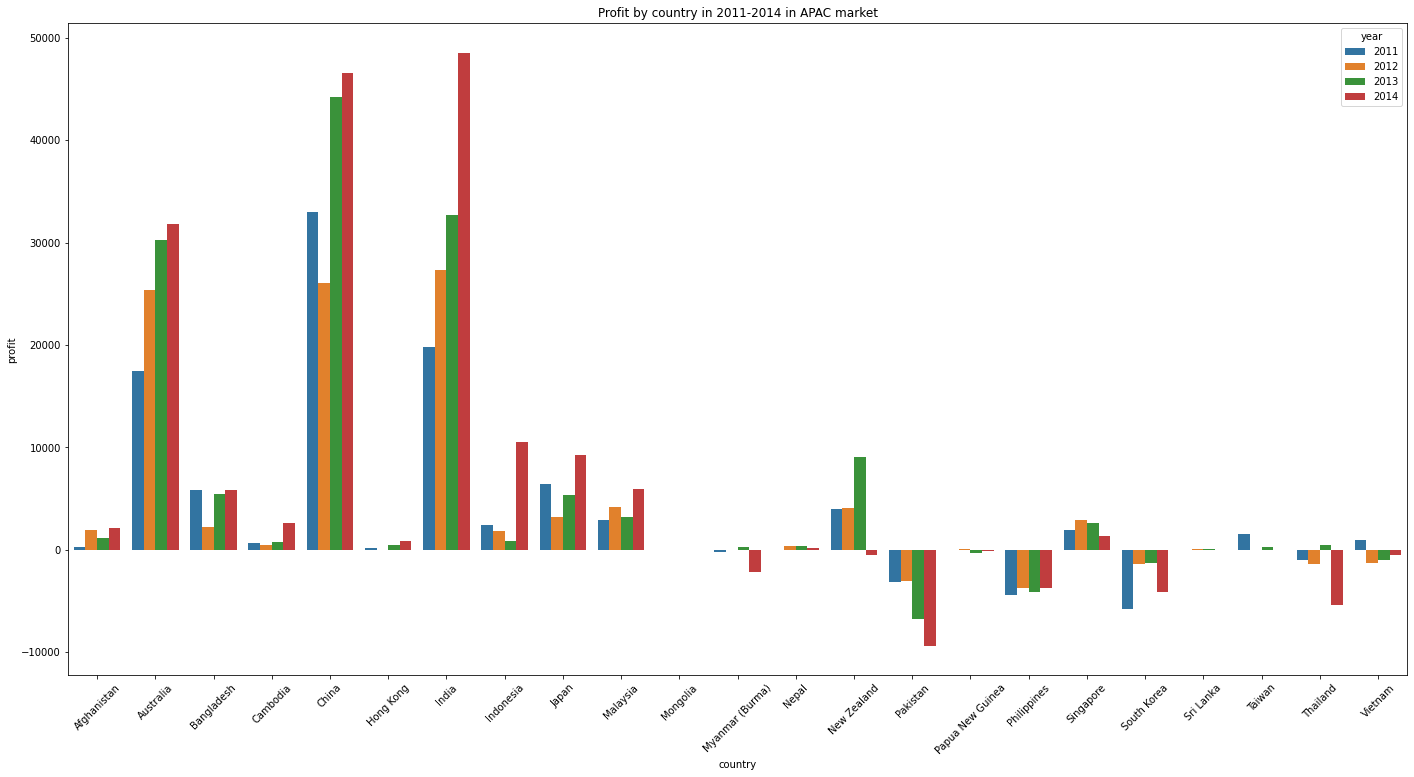

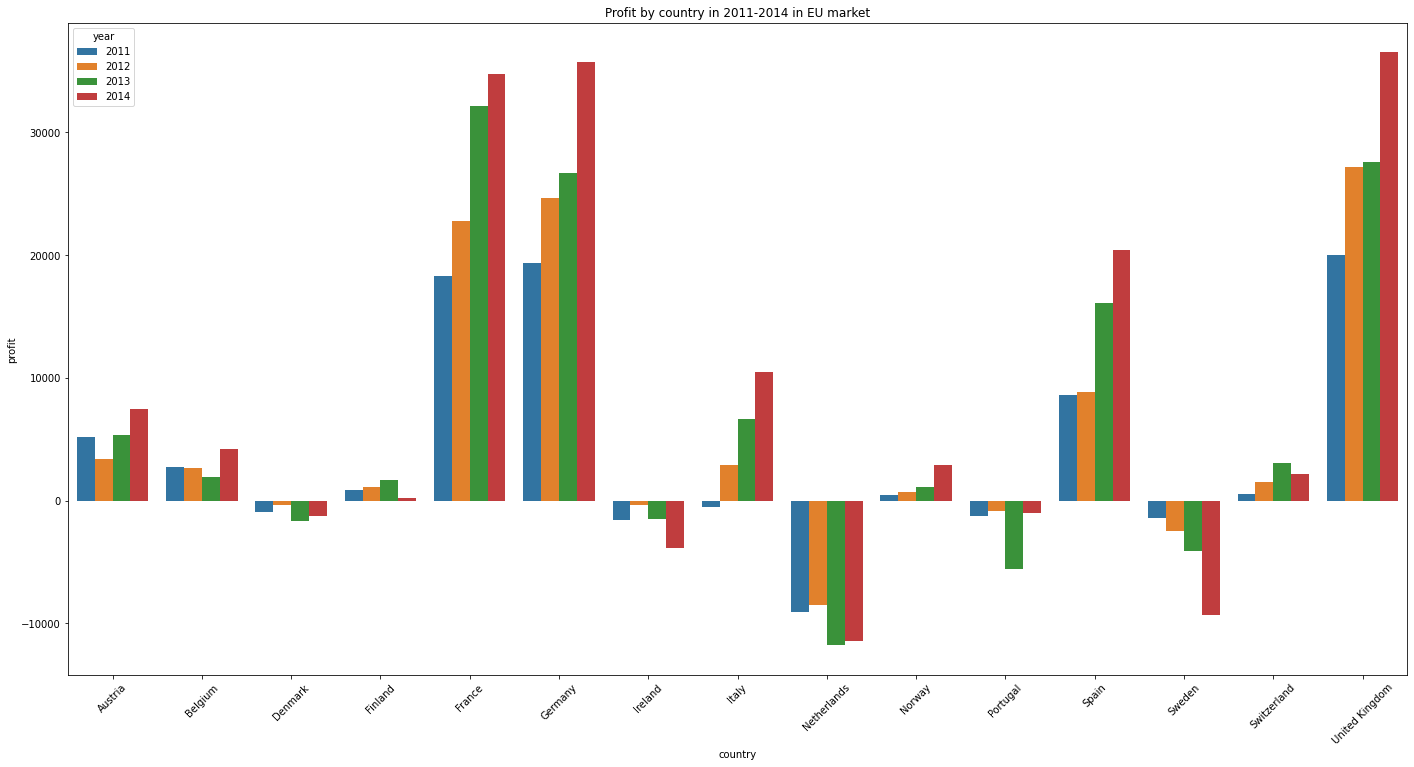

In [13]:
# markets: APAC, EU
market_countries = super_data.groupby(['market','country','year'])['profit'].sum().reset_index()
countries_apac = market_countries[market_countries['market'] == 'APAC'].reset_index()

plt.figure(figsize=[24,12])
sns.barplot(data=countries_apac, x='country', y='profit', hue='year')
plt.xticks(rotation=45)
plt.title("Profit by country in 2011-2014 in APAC market")
plt.show()

countries_eu = market_countries[market_countries['market'] == 'EU'].reset_index()

plt.figure(figsize=[24,12])
sns.barplot(data=countries_eu, x='country', y='profit', hue='year')
plt.xticks(rotation=45)
plt.title("Profit by country in 2011-2014 in EU market")
plt.show()

In [14]:
# most relevant data is considered for 2014
# region countries with dropping profits: Switzerland, US, Canada, Finland, Mongolia, Taiwan,
# region countries with negative profits: Honduras, the Netherlands, Panama, Denmark, Ireland, Sweden, South Korea, New Zealand*, Papua New Guinea* 
# market countries with dropping profits: Canada, US, Nepal, Singapore, Sri Lanka, Taiwan, Finland, Switzerland
# market countries with negative profits: Myanmar, New Zealand*, Pakistan, *Papua New Guinea, the Philippines, South Korea, Thailand*, Vietnam*, Denmark, Ireland, the Netherlands, Portugal, Sweden
# *countries used to have positive profits

# overlap countries with dropping profits: Switzerland, US, Canada, Finland, Taiwan
# overlap countries with negative profits: the Netherlands, Denmark, Ireland, Sweden, South Korea, New Zealand*, Papua New Guinea*, 
# *countries used to have positive profits

# Pt II: Customer segementation and bulk of profit. Most profitable customers.

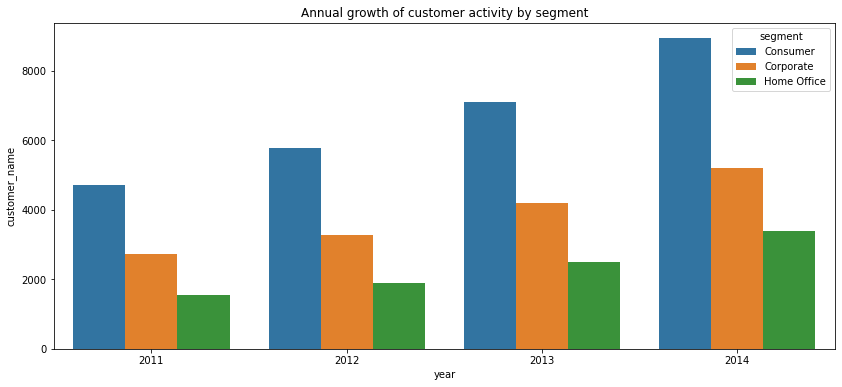

In [15]:
#customer engagement

customer_numbers = super_data.groupby(['year', 'segment'])['customer_name'].count().reset_index()
plt.figure(figsize=[14,6])
sns.barplot(data=customer_numbers, x='year', y='customer_name', hue='segment')
plt.title("Annual growth of customer activity by segment")
plt.show()

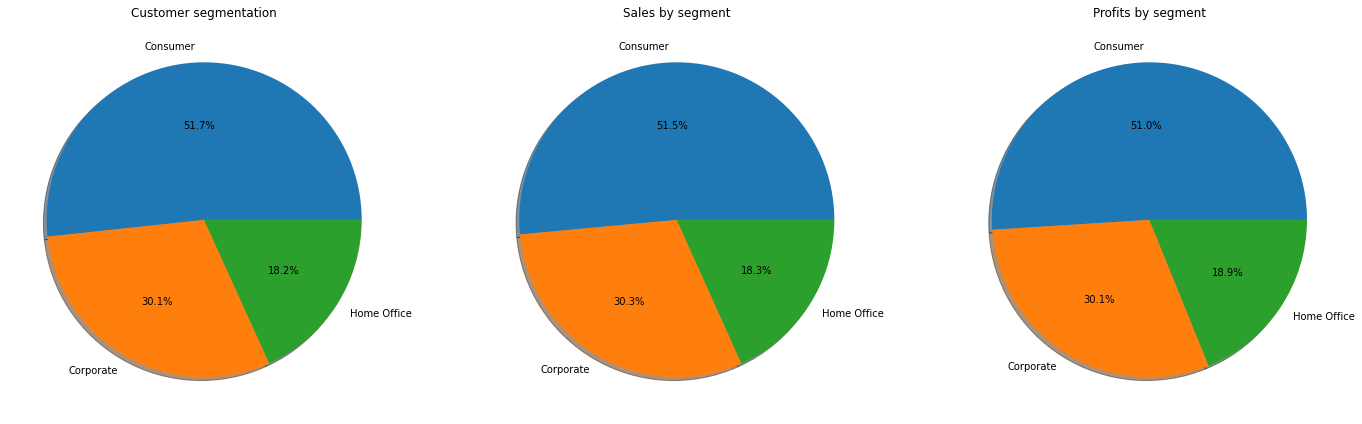

In [16]:
#global segmentation
segment_percentage = super_data['segment'].value_counts().reset_index()

#most sales by segment
most_sales_seg = super_data.groupby('segment')['sales'].sum().reset_index()

#most profit by segment
most_profit_seg = super_data.groupby('segment')['profit'].sum().reset_index()

#clear consumer predominance with the corporate coming second
plt.figure(figsize=[24,10])
plt.subplot(1,3,1)
plt.title('Customer segmentation')
plt.pie(segment_percentage['segment'], labels=segment_percentage['index'], autopct='%1.1f%%', shadow=True)
plt.subplot(1,3,2)
plt.title('Sales by segment')
plt.pie(most_sales_seg['sales'],labels=most_sales_seg['segment'], autopct='%1.1f%%', shadow=True)
plt.subplot(1,3,3)
plt.title('Profits by segment')
plt.pie(most_profit_seg['profit'],labels=most_profit_seg['segment'], autopct='%1.1f%%', shadow=True)
plt.show()

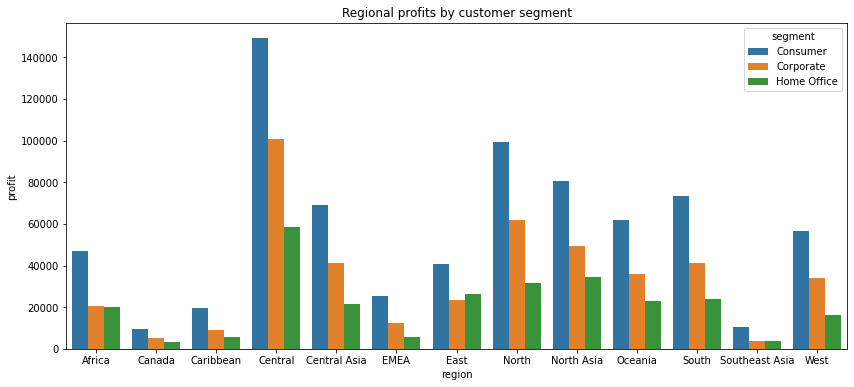

In [17]:
#regional profits by segment
region_seg_prof = super_data.groupby(['segment','region'])['profit'].sum().reset_index()
plt.figure(figsize=[14,6])
sns.barplot(data=region_seg_prof, x=region_seg_prof['region'], y=region_seg_prof['profit'], hue=region_seg_prof['segment'])
plt.title("Regional profits by customer segment")
plt.show()

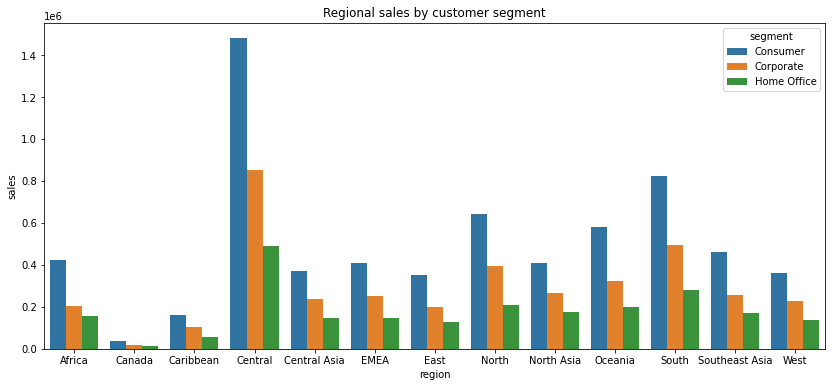

In [18]:
#regional sales by segment
region_seg_sales = super_data.groupby(['segment','region'])['sales'].sum().reset_index()
plt.figure(figsize=[14,6])
sns.barplot(data=region_seg_sales, x=region_seg_sales['region'], y=region_seg_sales['sales'], hue=region_seg_sales['segment'])
plt.title("Regional sales by customer segment")
plt.show()

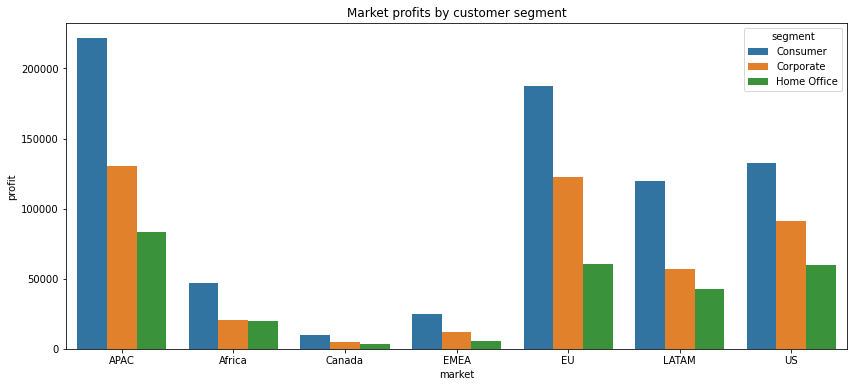

In [19]:
#market profit
market_seg_prof = super_data.groupby(['segment','market'])['profit'].sum().reset_index()
plt.figure(figsize=[14,6])
sns.barplot(data=market_seg_prof, x=market_seg_prof['market'], y=market_seg_prof['profit'], hue=market_seg_prof['segment'])
plt.title("Market profits by customer segment")
plt.show()

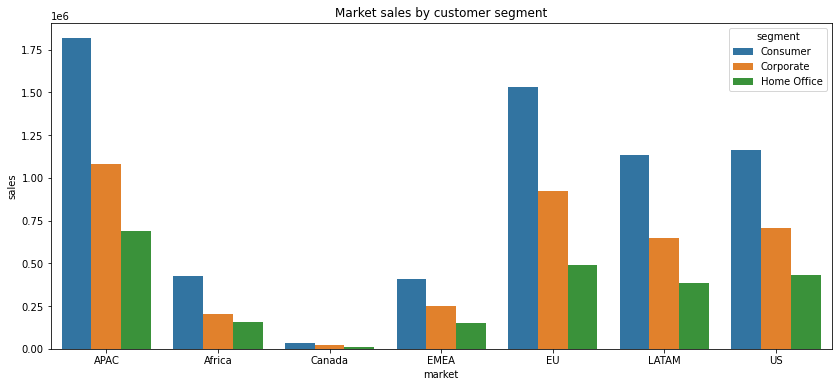

In [20]:
#market sales
market_seg_sales = super_data.groupby(['segment','market'])['sales'].sum().reset_index()
plt.figure(figsize=[14,6])
sns.barplot(data=market_seg_sales, x=market_seg_sales['market'], y=market_seg_sales['sales'], hue=market_seg_sales['segment'])
plt.title("Market sales by customer segment")
plt.show()

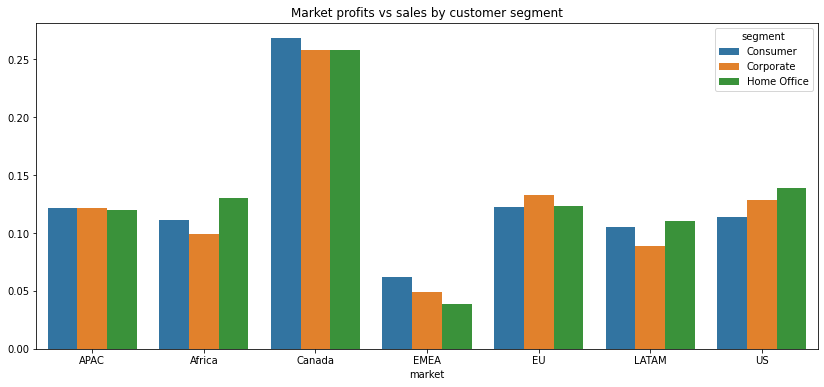

In [21]:
#profit-to-sales by market segment
plt.figure(figsize=[14,6])
sns.barplot(x=market_seg_sales['market'], y=market_seg_prof['profit'] / market_seg_sales['sales'], hue=market_seg_sales['segment'])
plt.title("Market profits vs sales by customer segment")
plt.show()

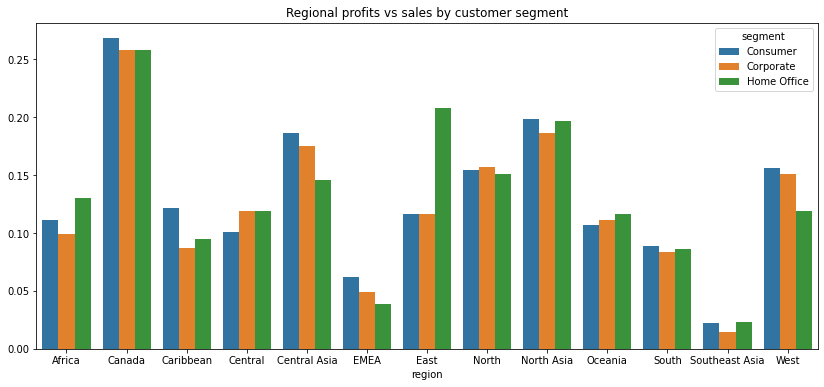

In [22]:
#segment profit vs sales
plt.figure(figsize=[14,6])
sns.barplot(x=region_seg_sales['region'], y=region_seg_prof['profit'] / region_seg_sales['sales'], hue=region_seg_sales['segment']).set_title('Regional profits vs sales by customer segment')
plt.show()

While both profits and sales for the consumer segment outweigh any other category, in terms of profit-to-sales ratio, some regions and markets benefit equally or even more from the corporate and home office segments.

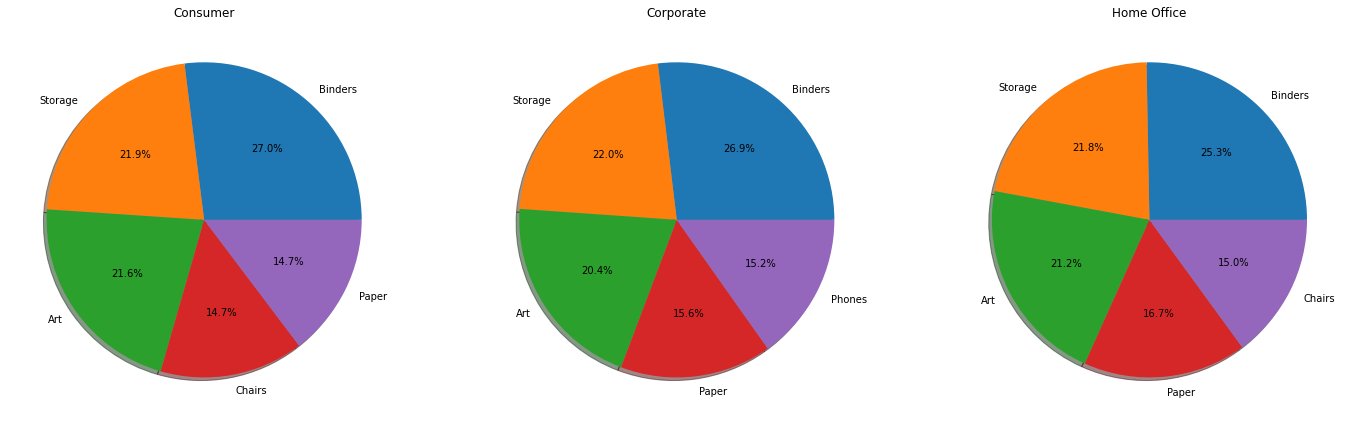

In [23]:
#most popular goods by segment
most_pop_consumer = super_data[super_data['segment'] == 'Consumer']['sub_category'].value_counts()[0:5].reset_index()
most_pop_corporate = super_data[super_data['segment'] == 'Corporate']['sub_category'].value_counts()[0:5].reset_index()
most_pop_home = super_data[super_data['segment'] == 'Home Office']['sub_category'].value_counts()[0:5].reset_index()

plt.figure(figsize=[24,10])
plt.subplot(1,3,1)
plt.title('Consumer')
plt.pie(most_pop_consumer['sub_category'], labels=most_pop_consumer['index'], autopct='%1.1f%%', shadow=True)
plt.subplot(1,3,2)
plt.title('Corporate')
plt.pie(most_pop_corporate['sub_category'], labels=most_pop_corporate['index'], autopct='%1.1f%%', shadow=True)
plt.subplot(1,3,3)
plt.title('Home Office')
plt.pie(most_pop_home['sub_category'], labels=most_pop_home['index'], autopct='%1.1f%%', shadow=True)
plt.show()

Storage, Binders and Art seem to be the most popular sub-categories among customers from all segments. Paper takes 4th place for Corporate and Home Office segments, with Phones and Chairs taking the last place for each of them respectively. Paper and Chairs seem to have equal poplarity (14.7%) for Consumers.

# Pt III: Popularity of goods by region, market, segment and year. Most profitable sub-categories in 2014.

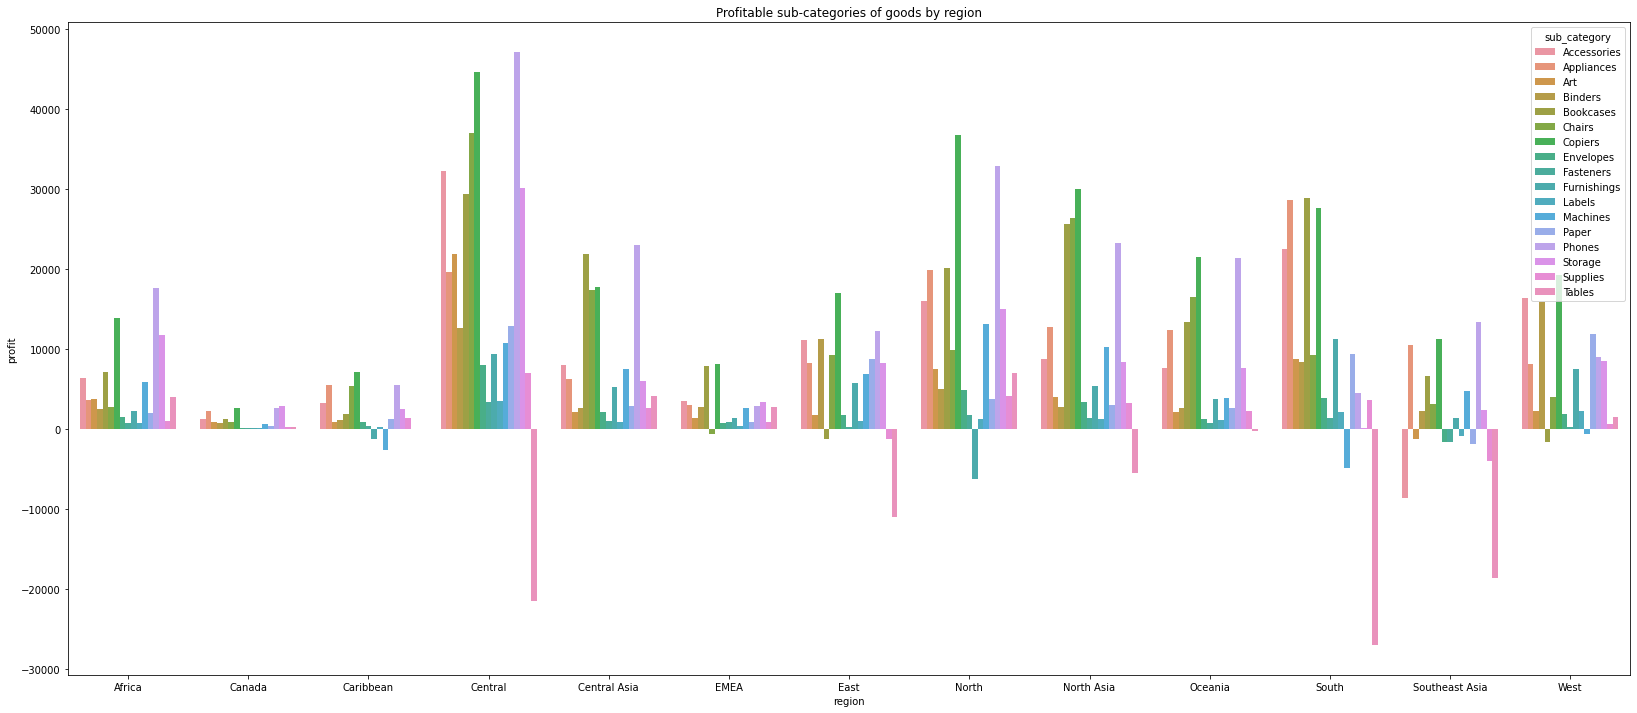

In [24]:
#profitable sub-categories of goods by region
profitable_cat_reg = super_data.groupby(['region', 'sub_category'])['profit'].sum().reset_index()
plt.figure(figsize=[28,12])
sns.barplot(data=profitable_cat_reg, x='region', y='profit', hue='sub_category').set_title('Profitable sub-categories of goods by region')
plt.show()

In [25]:
#variance in profit
profitable_cat_reg.groupby('sub_category')['profit'].var()

sub_category
Accessories    1.054428e+08
Appliances     6.108698e+07
Art            3.520432e+07
Binders        2.445990e+07
Bookcases      1.317174e+08
Chairs         1.199880e+08
Copiers        1.485751e+08
Envelopes      5.737915e+06
Fasteners      1.289211e+06
Furnishings    2.190127e+07
Labels         1.208127e+06
Machines       2.896647e+07
Paper          2.196486e+07
Phones         1.703297e+08
Storage        6.085696e+07
Supplies       7.214795e+06
Tables         1.220837e+08
Name: profit, dtype: float64

The worst-preforming sub-category in several regions is *tables*, showing negative profits in Central, East, North Asia, South, and Southeast Asian regions. The performance of other goods is consistently higher, without a clear pattern in negative profits.
Among well-performing categories we can name Phones and Copiers, while Supplies, Storage and Appliances show the highest variance in profit.

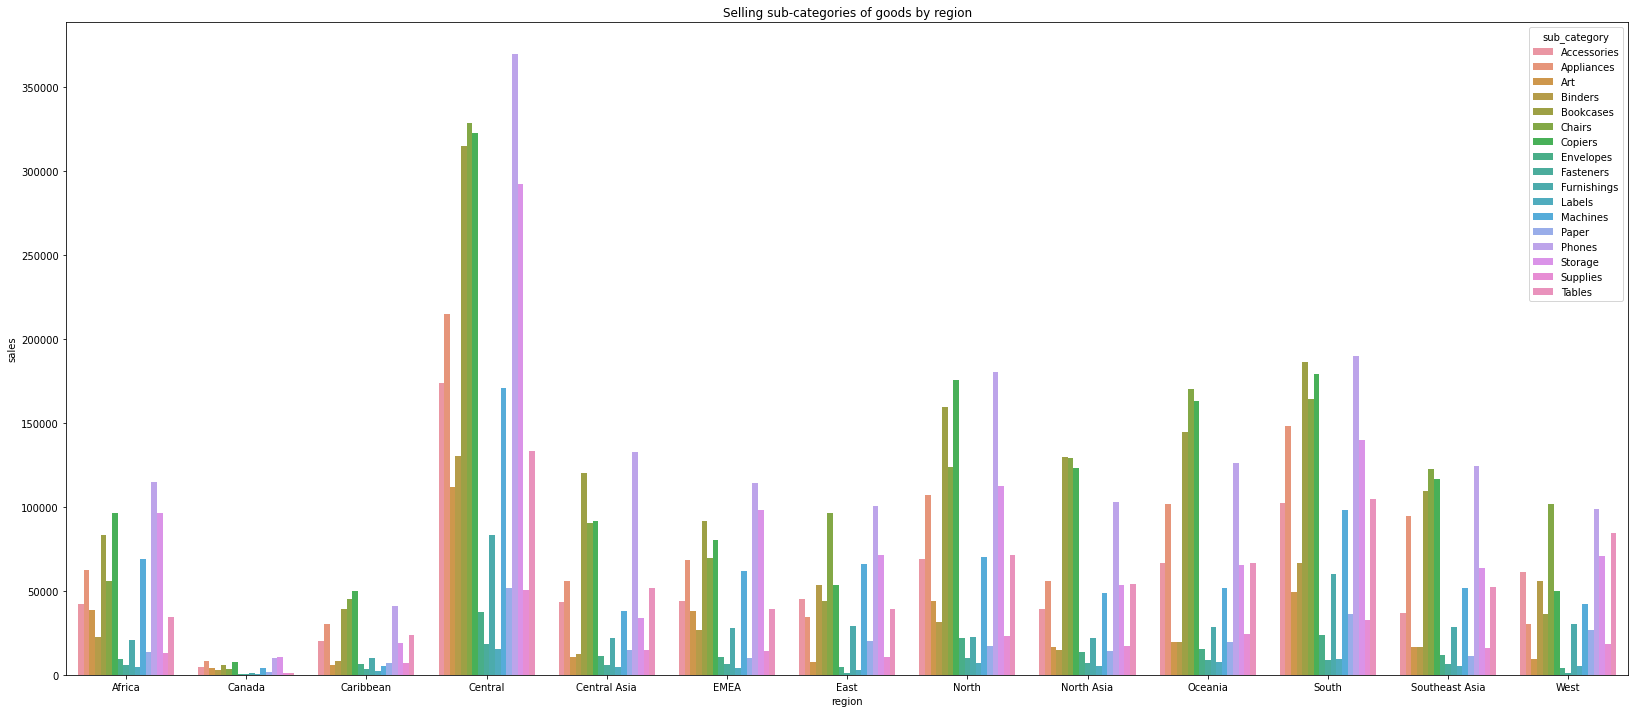

In [26]:
#best-selling sub-categories by region
selling_cat_reg = super_data.groupby(['region', 'sub_category'])['sales'].sum().reset_index()
plt.figure(figsize=[28,12])
sns.barplot(data=selling_cat_reg, x='region', y='sales', hue='sub_category').set_title('Selling sub-categories of goods by region')
plt.show()

Most sub-categories show reasonably high sales, except Art, Binders, Labels, Fasteners and Envelopes. With the exception of Art, which is a special category, the other carried items normally have lower prices. This, in combination with low sales, may lead to negative profits or other losses.

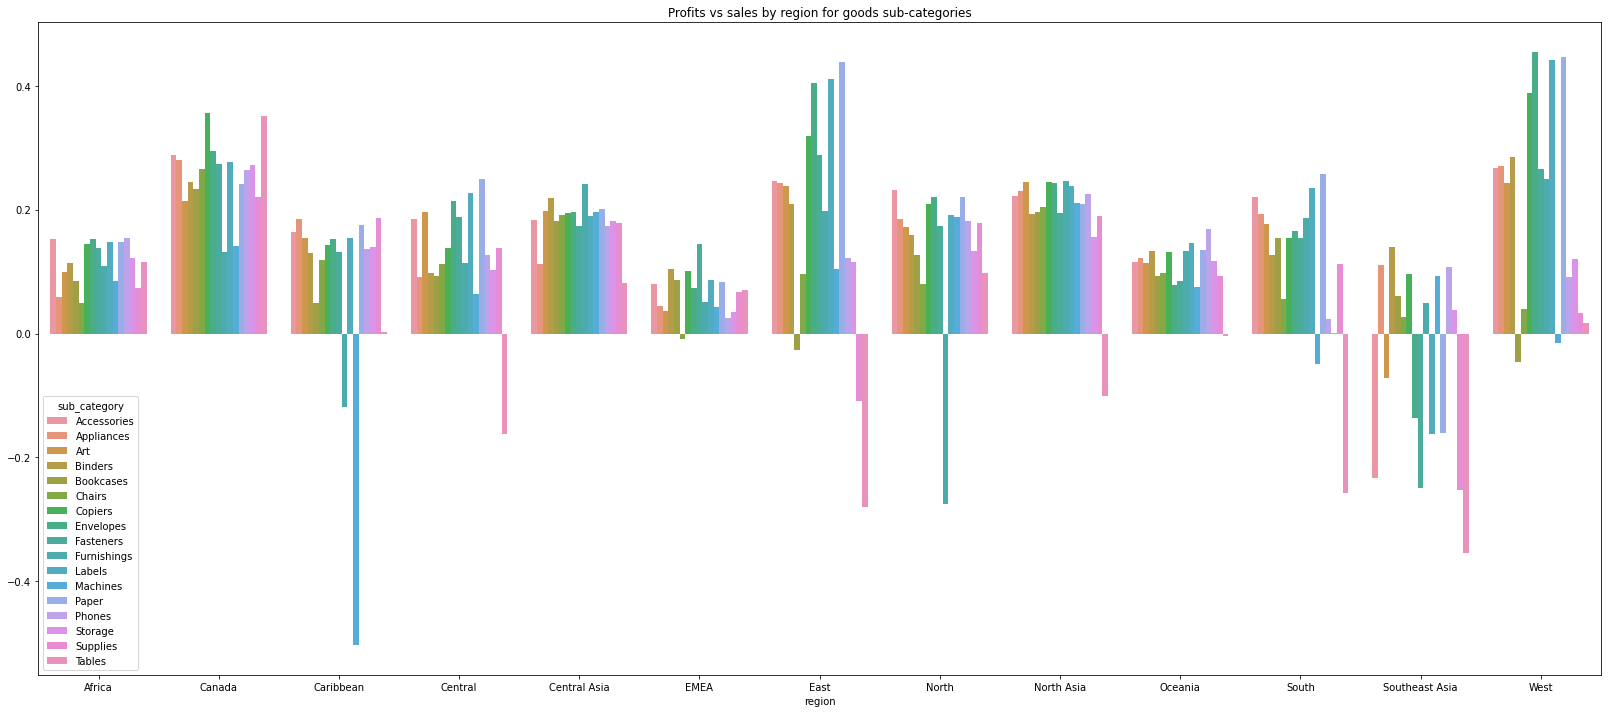

In [27]:
#profits to sales ratio for regions and goods
profit_sales_reg = profitable_cat_reg['profit'] / selling_cat_reg['sales']
plt.figure(figsize=[28,12])
sns.barplot(x=selling_cat_reg['region'], y=profit_sales_reg, hue=profitable_cat_reg['sub_category']).set_title('Profits vs sales by region for goods sub-categories')
plt.show()

As expected, tables show a negative proprtion of profits to sales. More surprising, however, are the results for Southeast Asia, which displays a negative trend for 8 out of 17 sub-categories of goods,and the Carribean, with a highly negative trend for the Machines sub-category. These findings may require additional research.

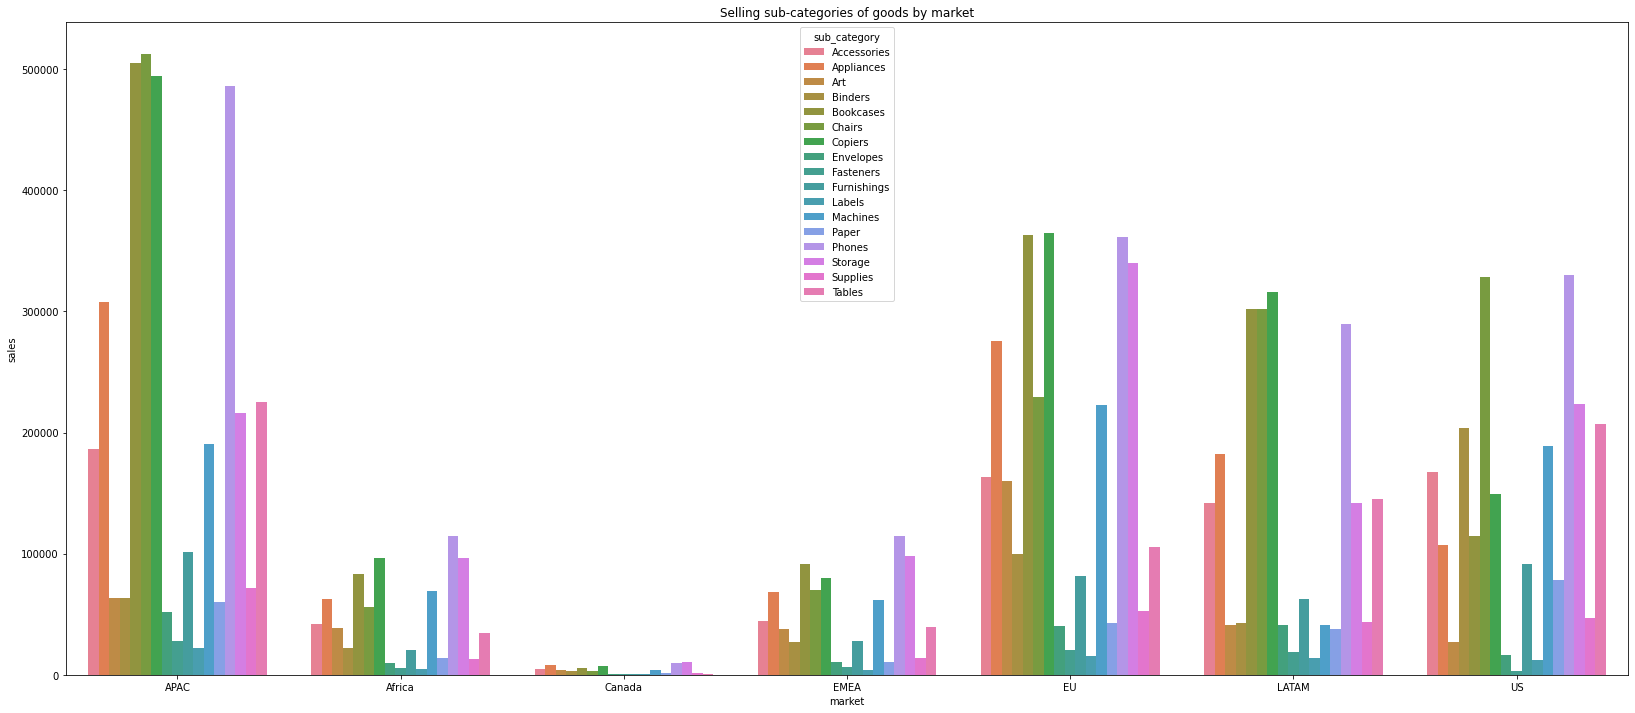

In [28]:
#market analysis of goods
#best-selling categories by market
selling_cat_market = super_data.groupby(['market', 'sub_category'])['sales'].sum().reset_index()
plt.figure(figsize=[28,12])
sns.barplot(data=selling_cat_market, x='market', y='sales', hue='sub_category', palette='husl').set_title("Selling sub-categories of goods by market")
plt.show()

Sales remain similar across markets as well - Phones and Copiers are in the lead, with the addition of Bookcases and Machines for some areas. Envelopes, Fasteners, Labels, Supplies and Paper are at a disadvantage.

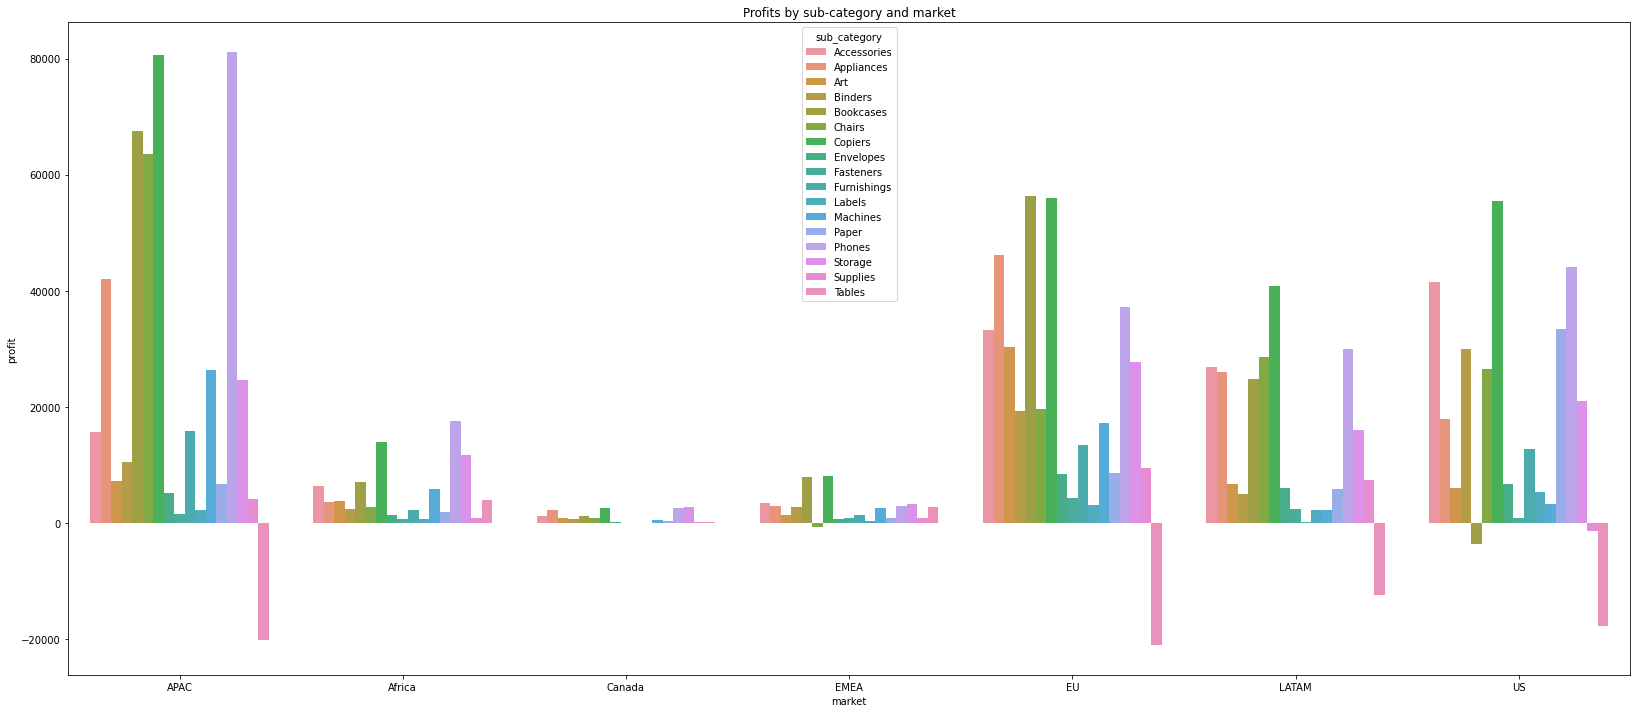

In [29]:
#profit by sub-category and market
profitable_cat_market = super_data.groupby(['market', 'sub_category'])['profit'].sum().reset_index()
plt.figure(figsize=[28,12])
sns.barplot(data=profitable_cat_market, x='market', y='profit', hue='sub_category').set_title("Profits by sub-category and market")
plt.show()

There is a better picture for markets, compared to regions. Tables also generate negative profits in APAC, EU, LATAM and US markets, but other categories, such as Chairs, Bookcases and Supplies in EMEA and US respectively, show only a minor dip.

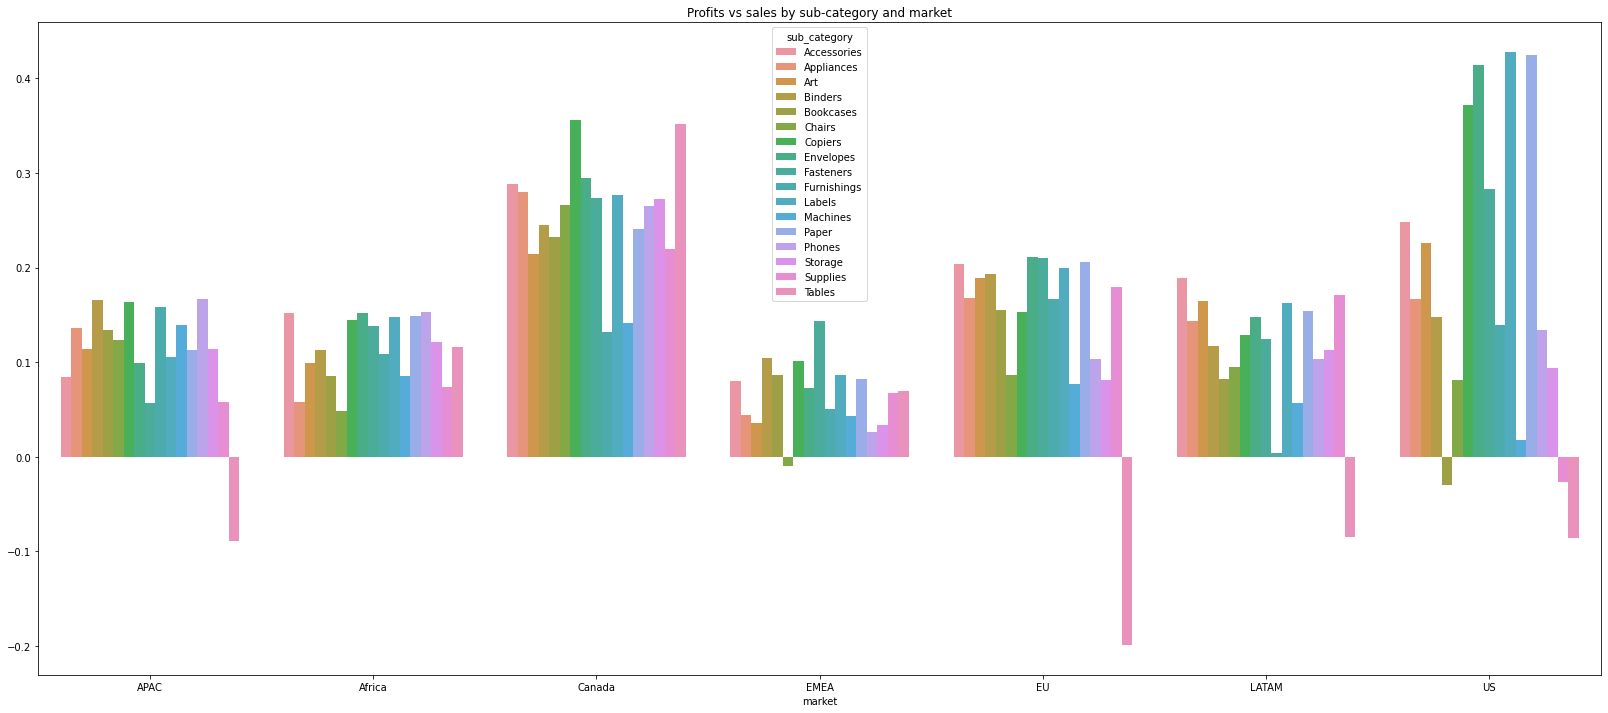

In [30]:
#profits-to-sales by sub-category and market overall 
profit_sales_market = profitable_cat_market['profit'] / selling_cat_market['sales']
plt.figure(figsize=[28,12])
sns.barplot(x=selling_cat_market['market'], y=profit_sales_market, hue=profitable_cat_market['sub_category']).set_title("Profits vs sales by sub-category and market")
plt.show()

The strongest profit-to-sales ratio overall is visible in Canada, with the other markets keeping positive for all sub-categories, except Tables for the APAC, US, LATAM, EU markets, Supplies and Bookcases in the US, Chairs in EMEA, and extremely low ratio for Furnishings in LATAM.

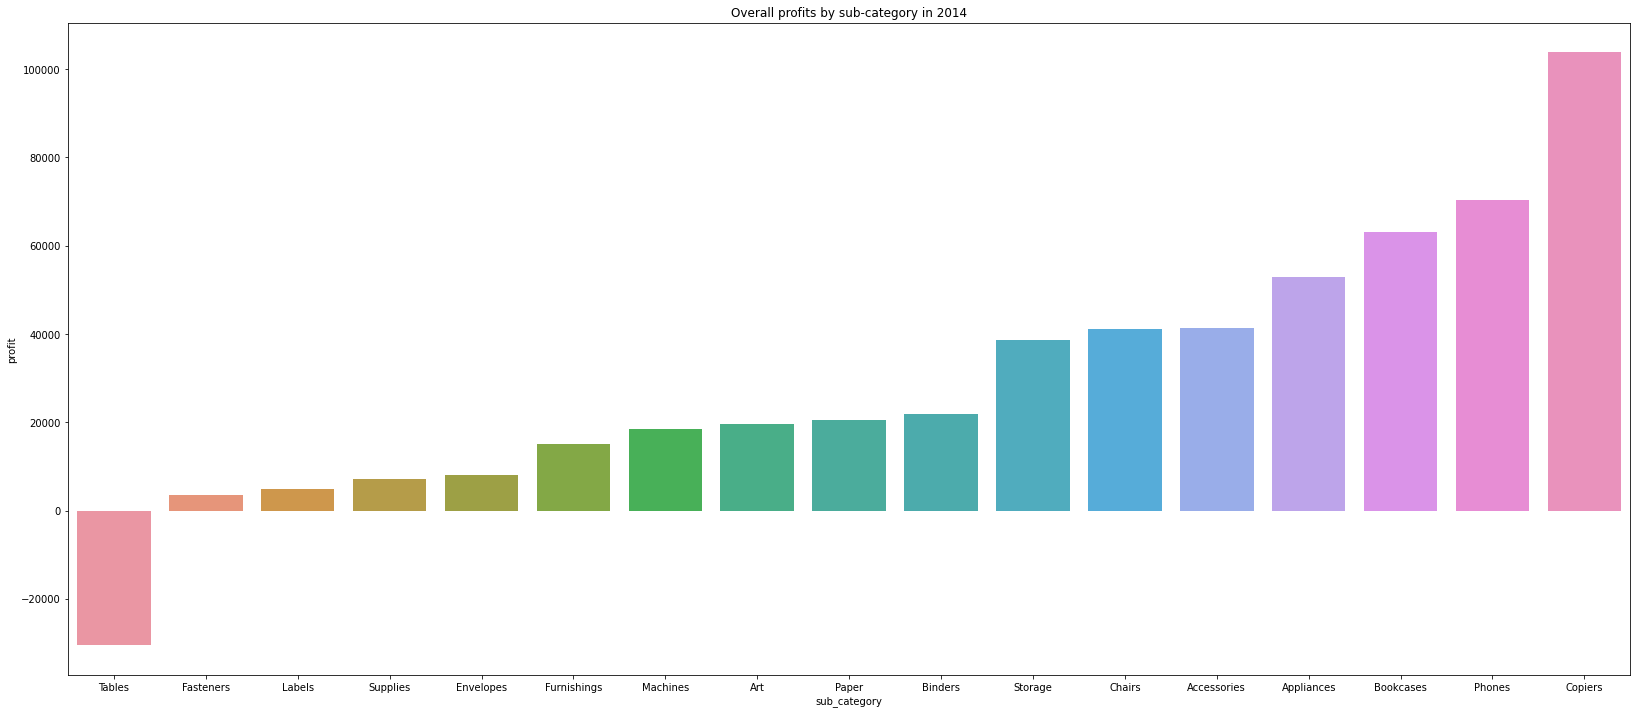

In [31]:
#as profits have the most dramatic discrepancy with sales in 2014, it may prove useful to analyse profits and sales by sub-category of goods in 2014
profitable_cat_2014 = super_data.groupby(['year', 'sub_category'])['profit'].sum().reset_index()
plt.figure(figsize=[28,12])
sns.barplot(data=profitable_cat_2014[profitable_cat_2014['year'] == 2014].sort_values(by='profit'), x='sub_category', y='profit').set_title("Overall profits by sub-category in 2014")
plt.show()

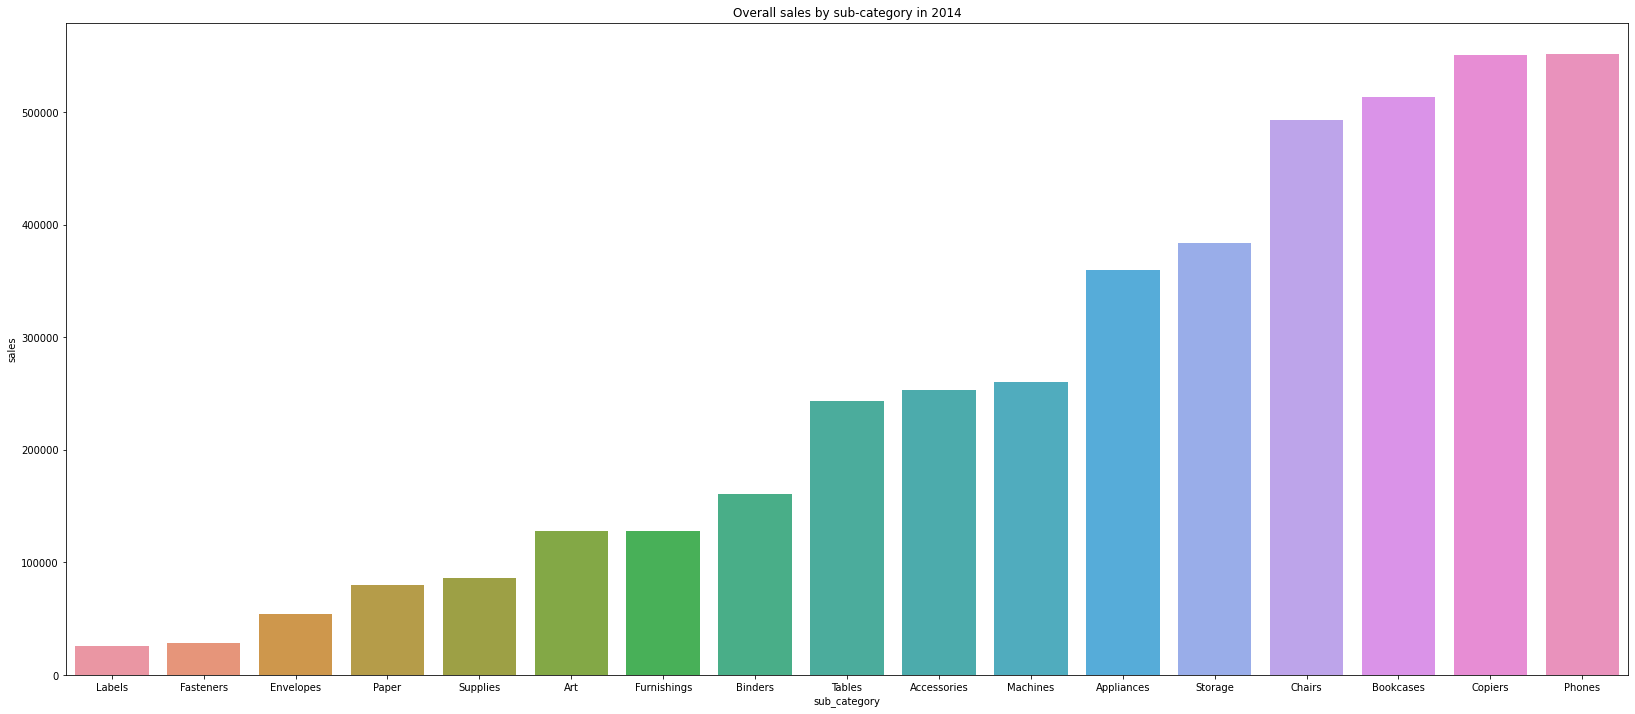

In [32]:
sold_cat_2014 = super_data.groupby(['year', 'sub_category'])['sales'].sum().reset_index()
plt.figure(figsize=[28,12])
sns.barplot(data=sold_cat_2014[sold_cat_2014['year'] == 2014].sort_values(by='sales'), x='sub_category', y='sales').set_title("Overall sales by sub-category in 2014")
plt.show()

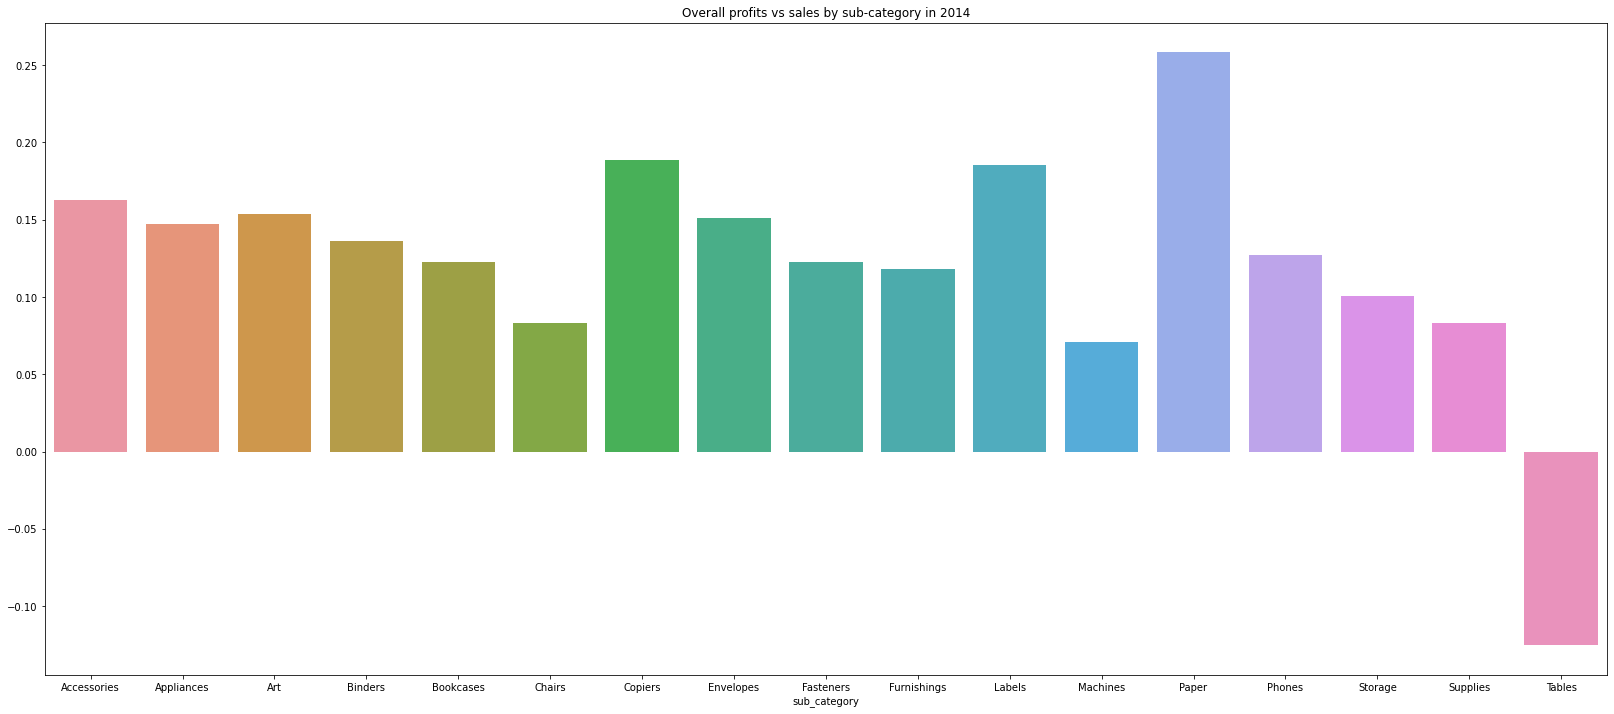

In [33]:
ratio_2014 = profitable_cat_2014[profitable_cat_2014['year'] == 2014]['profit'] / sold_cat_2014[sold_cat_2014['year'] == 2014]['sales']
plt.figure(figsize=[28,12])
sns.barplot(x=profitable_cat_2014['sub_category'], y=ratio_2014).set_title("Overall profits vs sales by sub-category in 2014")
plt.show()

Labels, Fasteners and Supplies show both low sales and low profits. Profit from Tables remains below zero, whereas there are healthy sales.
In terms of the ratio, only two sub-categories - Chairs and Machines - go under 0.1, and Tables show a negative one.

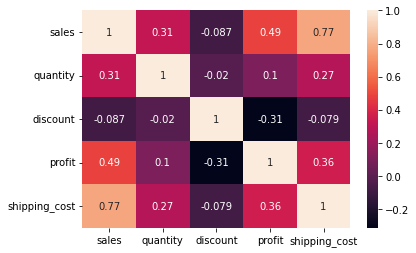

In [34]:
#more columns for analysis, based on correlation with sales and profits - quantity, shipping cost, and discount
#no influence possible on quantity, others - to be analysed
corr_a = super_data.corr()
sns.heatmap(corr_a, annot=True)
plt.show()

In [35]:
#introducing several categories to check correlation
super_data['ship_mode'] = super_data['ship_mode'].astype('category')
super_data['segment'] = super_data['segment'].astype('category')
super_data['market'] = super_data['market'].astype('category')
super_data['region'] = super_data['region'].astype('category')
super_data['sub_category'] = super_data['sub_category'].astype('category')
super_data['order_priority'] = super_data['order_priority'].astype('category')

#encoding categories to see more correspondence. Since markets and regions may potentially have many correlations and high dimensionality, we will do separate calculations for both
onehot_seg = pd.get_dummies(super_data['segment'])
onehot_prior = pd.get_dummies(super_data['order_priority'])
onehot_mode = pd.get_dummies(super_data['ship_mode'])
onehot_reg = pd.get_dummies(super_data['region'])
onehot_mark = pd.get_dummies(super_data['market'])
onehot_cat = pd.get_dummies(super_data['sub_category'])

In [36]:
summary  = pd.concat([super_data, onehot_seg, onehot_cat, onehot_mode, onehot_prior, onehot_reg, onehot_mark], axis=1)
corr = summary.corr()
sales_positive_cor = corr[corr['sales'] > 0.09]
sales_negative_cor = corr[corr['sales'] < -0.09]
#sales are positively correlated with quantity (0.31), profit (0.49) and strongly with shipping cost (0.77)
#sales have a negative correlation with underperforming sub-categories
profit_positive_cor = corr[corr['profit'] > 0.09]
profit_negative_cor = corr[corr['profit'] < -0.09]
# profits are positively correlated with sales, shipping cost, where they have coefficients of 0.49 and 0.36 respectively, and quantity (0.1)
# profits are negatively correlated with discounts (-0.31)

# Pt VI: Shipping prices and preferences

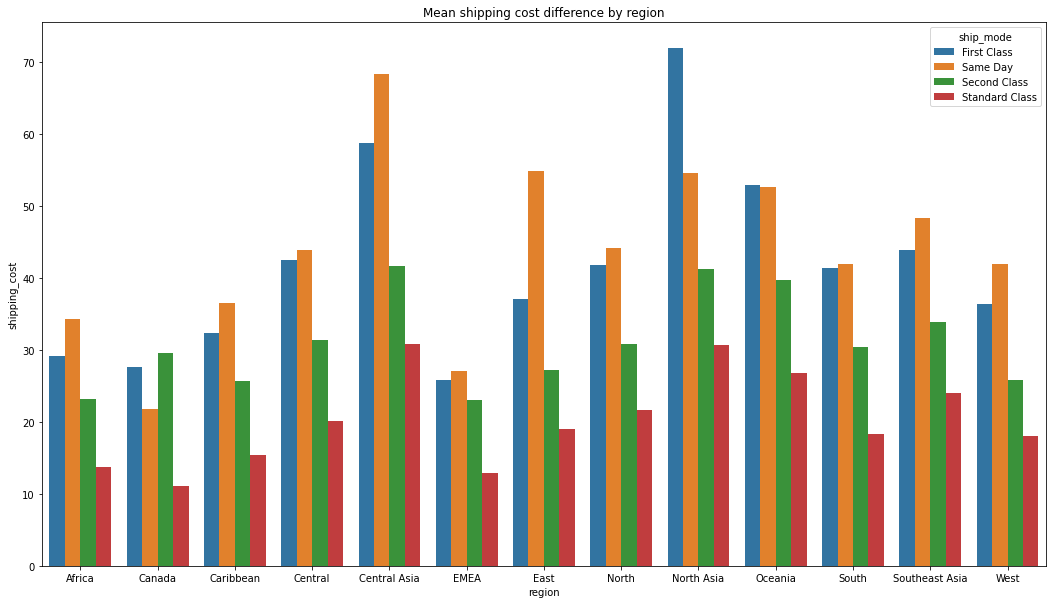

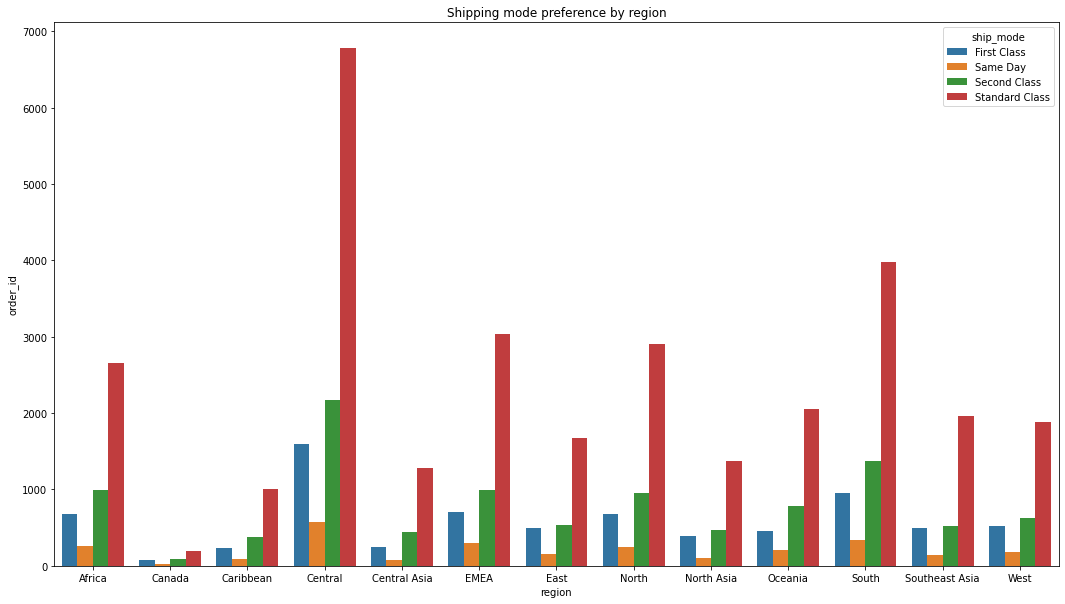

In [37]:
#mean shipping price difference by region
mean_shipping = super_data.groupby(['region', 'ship_mode'])['shipping_cost'].mean().reset_index()
plt.figure(figsize=[18,10])
sns.barplot(data=mean_shipping, x='region', y='shipping_cost', hue='ship_mode').set_title('Mean shipping cost difference by region')
plt.show()

#shipping preferences by region:
shipping_pref_reg = super_data.groupby(['region', 'ship_mode'])['order_id'].count().reset_index()
plt.figure(figsize=[18,10])
sns.barplot(data=shipping_pref_reg, x='region', y='order_id', hue='ship_mode').set_title('Shipping mode preference by region')
plt.show()

Customer preference for shipping modes is inversely proportional to the increase in shipping cost to a particular region.

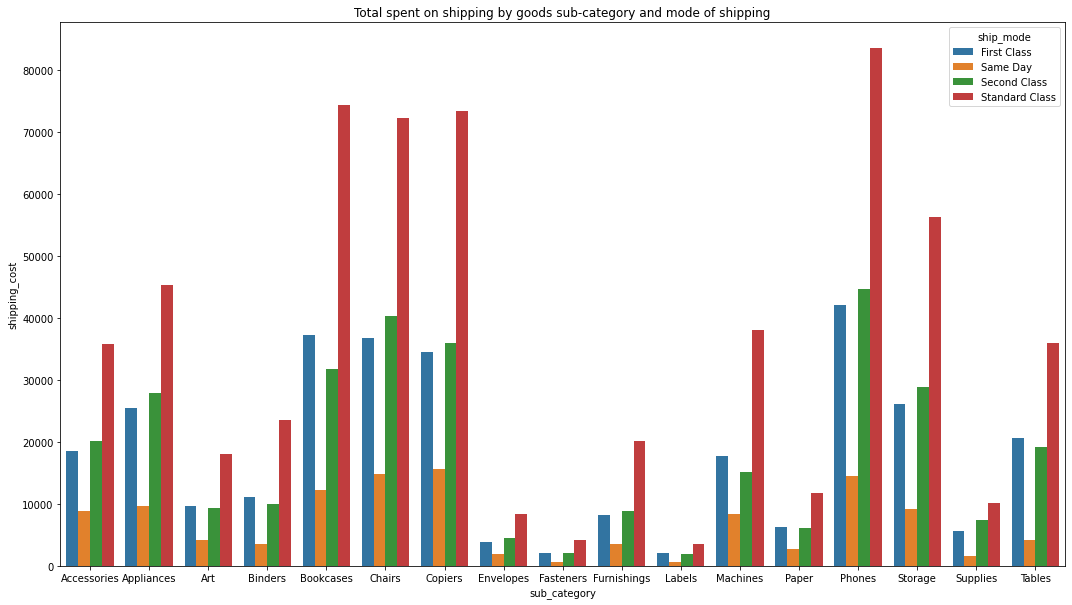

In [38]:
shipping_price_cat = super_data.groupby(['sub_category', 'ship_mode'])['shipping_cost'].sum().reset_index()
plt.figure(figsize=[18,10])
sns.barplot(data=shipping_price_cat, x='sub_category', y='shipping_cost', hue='ship_mode').set_title('Total spent on shipping by goods sub-category and mode of shipping')
plt.show()

All sub-categories of goods are typically shipped Standard Class, which results in a huge dominance in spending, and, as a result, earnings bu SuperStore. Similar spending can be observed for First and Second Class shipping, with Same Day shipping being far less popular.

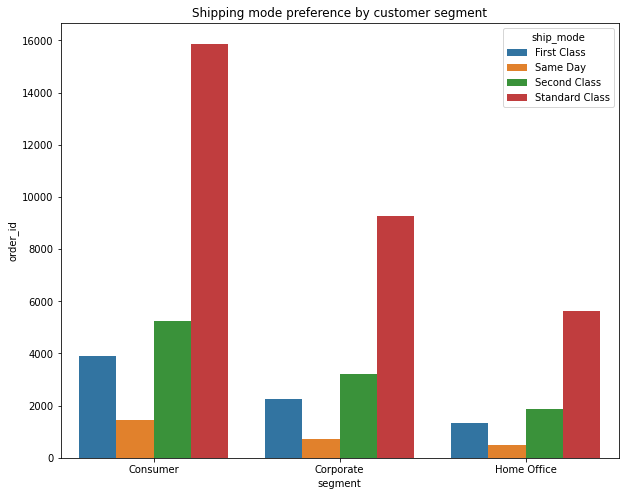

In [39]:
#shipping preferences by segment:
shipping_pref_cust = super_data.groupby(['segment', 'ship_mode'])['order_id'].count().reset_index()
plt.figure(figsize=[10,8])
sns.barplot(data=shipping_pref_cust, x='segment', y='order_id', hue='ship_mode').set_title('Shipping mode preference by customer segment')
plt.show()

Customer preferences by segment show no deviations from the regional and market observations.

# Pt V: Discounts vs profits vs sales

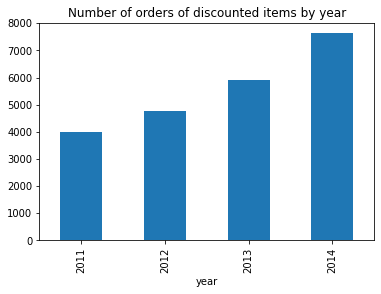

In [40]:
#do discounts have a positive or negative impact on sales and profits?
disc_goods = super_data.query('discount > 0')
disc_goods.groupby('year')['order_id'].count().plot(kind='bar')

plt.title('Number of orders of discounted items by year')
plt.show()

As evident from the graph, the number of orders that include discounted items has increased over the years.

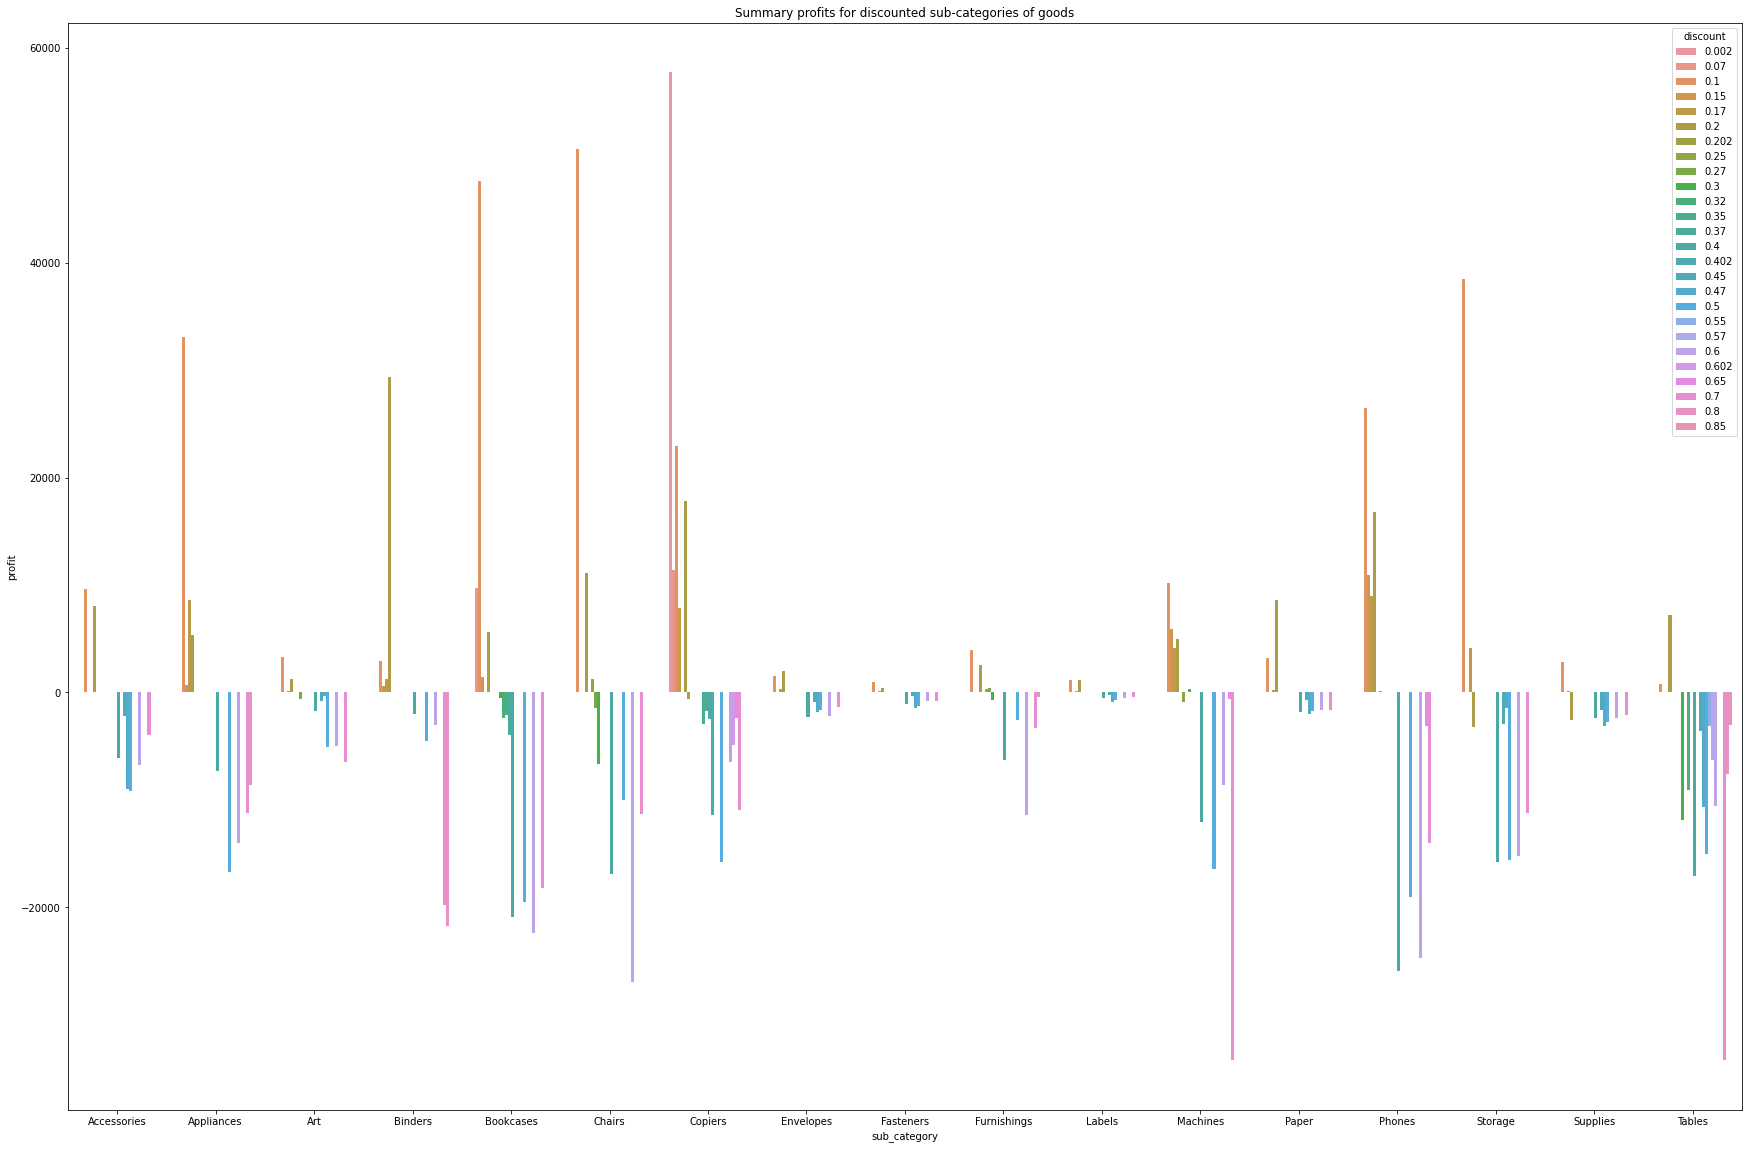

In [41]:
#profits for discounted items by sub-category
goods_profits = disc_goods.groupby(['sub_category', 'discount'])['profit'].sum().reset_index()
plt.figure(figsize=[30,20])
sns.barplot(x=goods_profits['sub_category'], y=goods_profits['profit'], hue=goods_profits['discount']).set_title('Summary profits for discounted sub-categories of goods')
plt.show()

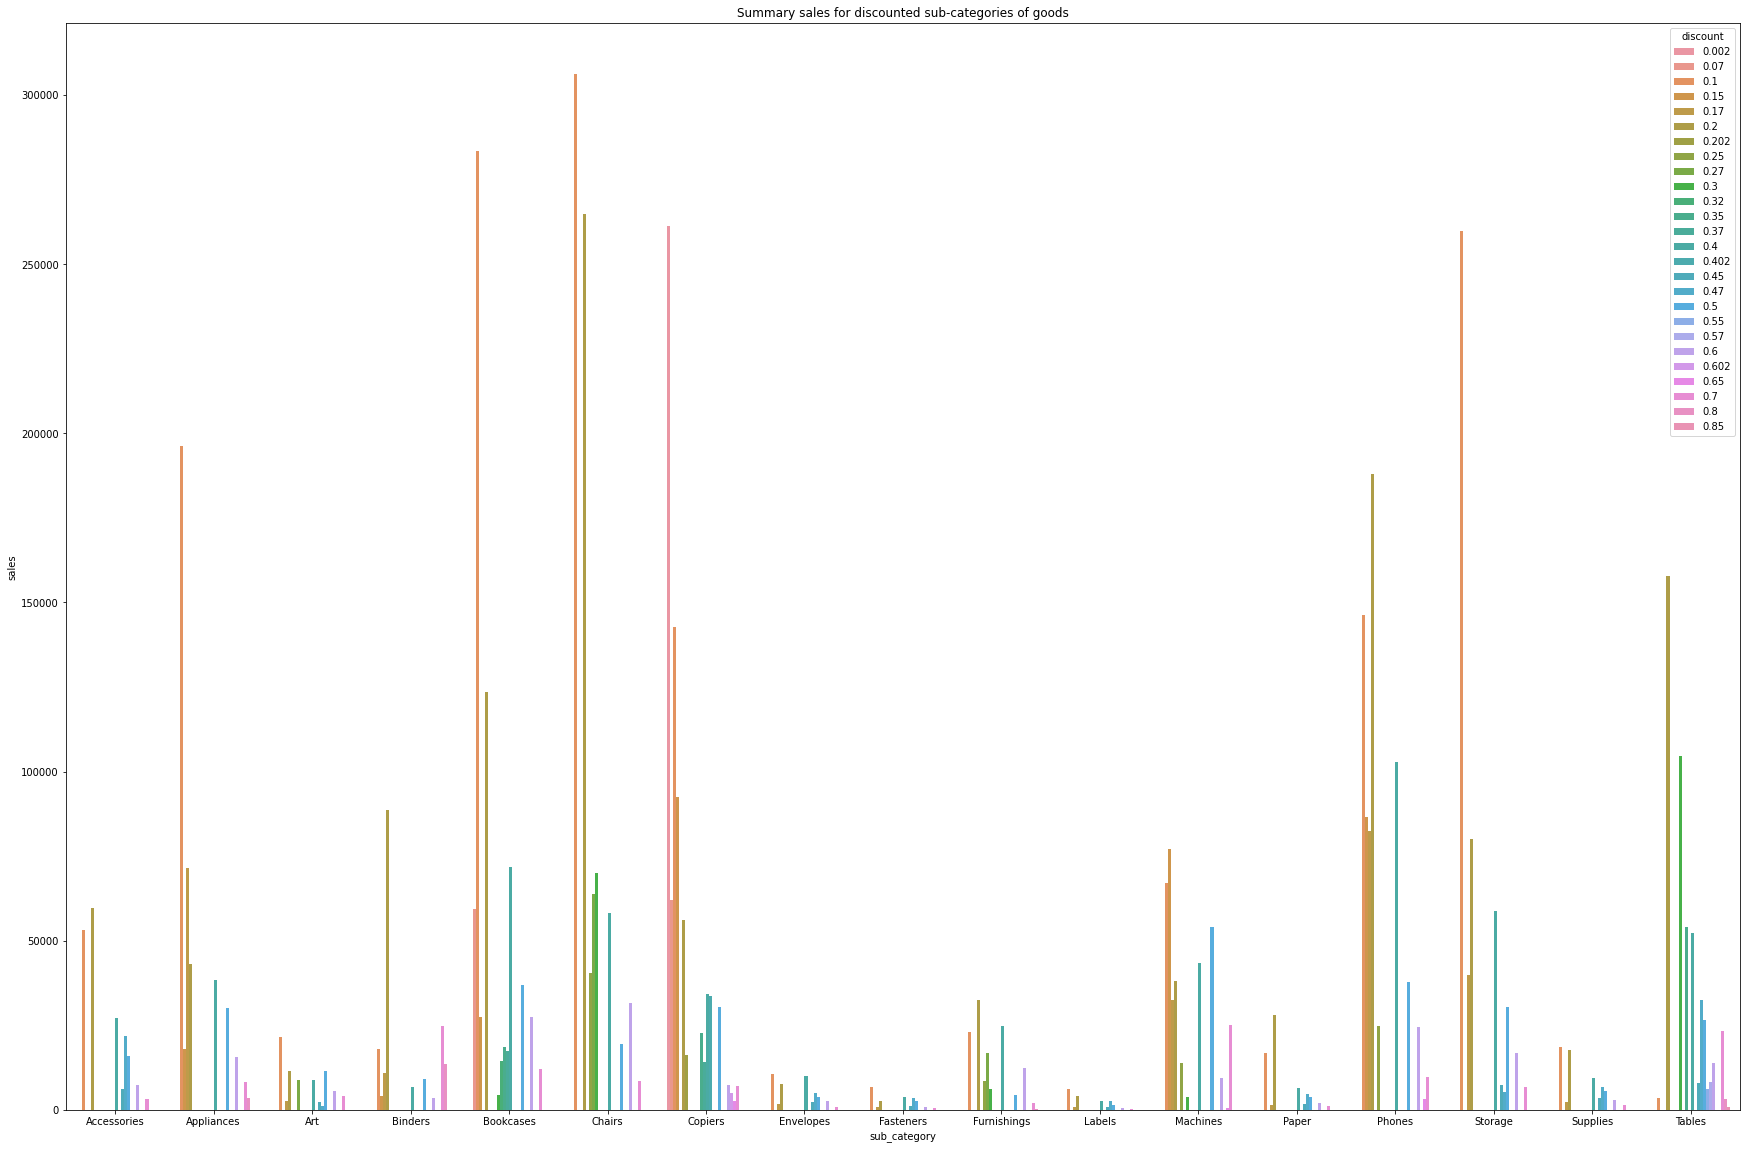

In [42]:
#sales for the discounted sub-categories
goods_sales = disc_goods.groupby(['sub_category', 'discount'])['sales'].sum().reset_index()
plt.figure(figsize=[30,20])
sns.barplot(x=goods_sales['sub_category'], y=goods_sales['sales'], hue=goods_sales['discount']).set_title('Summary sales for discounted sub-categories of goods')
plt.show()
plt.show()

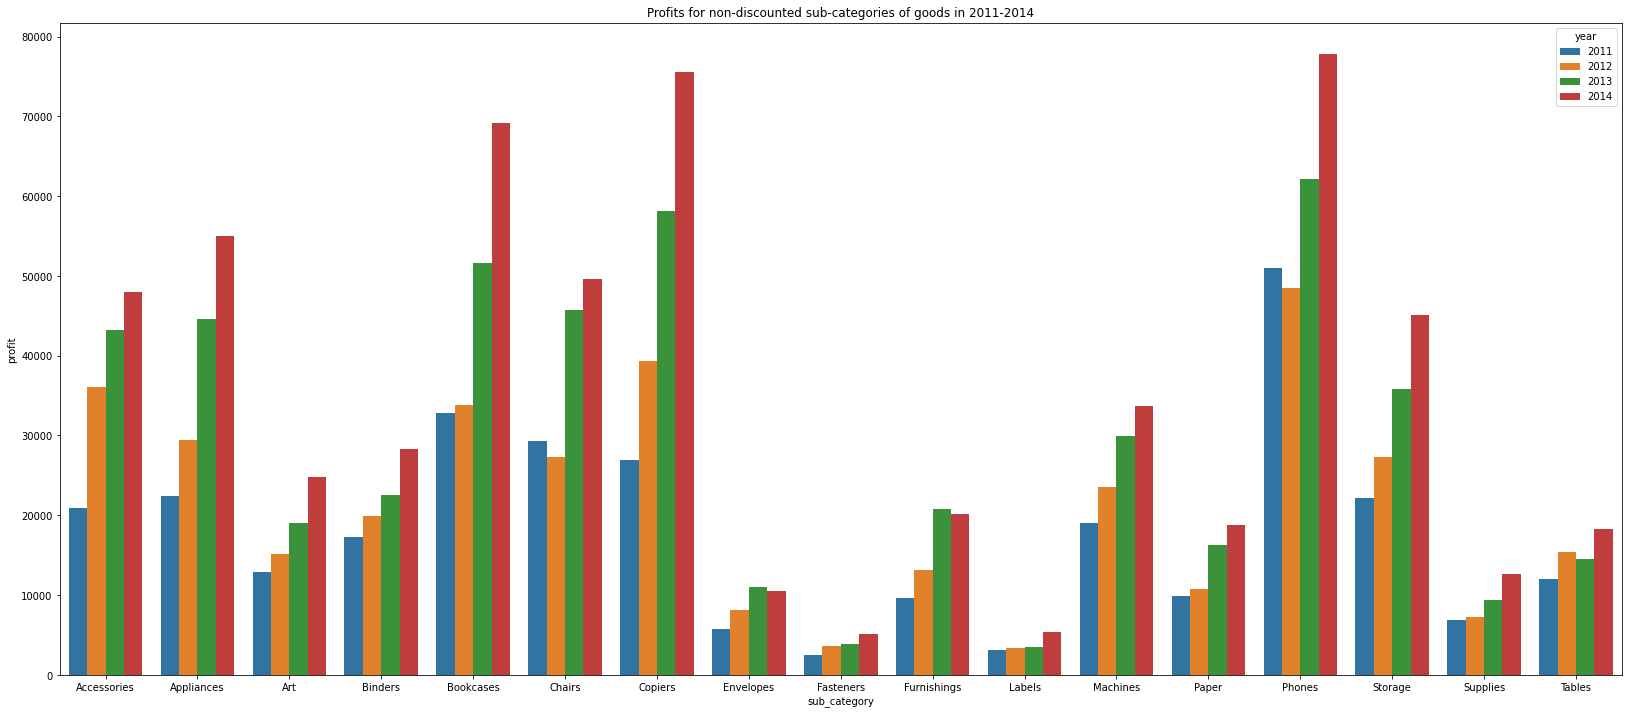

In [43]:
#profits for non-discounted goods
ndisc_goods = super_data.query('discount == 0')
ngoods_profits = ndisc_goods.groupby(['sub_category', 'year'])['profit'].sum().reset_index()
plt.figure(figsize=[28,12])
sns.barplot(data=ngoods_profits, x='sub_category', y='profit', hue='year').set_title('Profits for non-discounted sub-categories of goods in 2011-2014')
plt.show()

As can be seen from the charts, sub-categories with the biggest discounts (above 30%) have the biggest loss in profit. Moreover, sales remain strong for items with the smallest discounts, and profits remain above zero for non-discounted items. All sub-categories, except Envelopes and Furnishings, show growth in 2014. Therefore, discounts are likely to damage profits but do not guarantee an increase in sales.

# Summary observations and suggestions

To decrease the running gap between sales and profits for SuperStore, there are a number of measures that can be taken to boost company earnings in underperforming regions and markets, focusing specifically on countries that show the worst profit-to-sales correlation, and the disproportionally high shipping prices for those regions and countries. 

Additionally, customer engagement can be improved by targeting corporate and home office segments. While not the majority, they account for a healthy ratio of correlation between profits and sales both in regional and market statistics, and can further increase the sales and profits of such sub-categories of goods as phones, chairs, paper and art.

There are several sub-categories of goods that can either be cut from the inventory or less heavily discounted. This includes tables, binders, labels, fasteners and envelopes that show poor performance across regional and market analyses. Discounts themselves do not influence sales in a meaningful way but significantly reduce profits.